## Main code to analyse preservation trends in bar packages. 
Inputs = CSVs with bar stats, and various input arrays for package statistics

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from matplotlib import cm
from pylab import *
import matplotlib.colors as mcol
from matplotlib.colors import LinearSegmentedColormap


import os
import seaborn as sns
from os import listdir
from os.path import isfile, join
import scipy.stats as stats

In [80]:
## Set Color maps for plots and plot aesthetics

coher_cols = ['#276419', '#9ccf64', '#f7f7f7', '#e896c4', '#8e0152'] ##PiYG 5 steps
coher_cols_seq = ['#d8ffff', '#85d9f0', '#2cb0e0', '#0083c6', '#0057a7'] #light blue to blue
# pres_cols = ['xkcd:pink', 'xkcd:lavender', 'xkcd:light grey'] #pink = FP, lav = PP, blue = TR
pres_cols = ['xkcd:primary blue', 'xkcd:soft blue', 'xkcd:pink red']
pres_cols = ['#e08266', '#feb9a8', '#8da0ae']##for SANCAS and AGU
proc_cols = ['#ff8500', '#ffca20', '#ffffe0', '#bf74e7', '#8044da'] #(orange to purple) agg to lat acc
pres_palette = sns.color_palette(pres_cols)
coh_palette = sns.color_palette(coher_cols_seq)
proc_palette = sns.color_palette(proc_cols)

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

Import files

In [3]:
## import datamaster for comparative statistics
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'
eqt = 65

datnam = f'{idf}-datamaster-{intstring}-ud.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are

datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

In [33]:
## import widening rates
#profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh210km-profile.npy') ## channel profile for each timestep
profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/channel-profile-ud.npy') ## channel profile for each timestep
profile_master[:eqt, :, :] = np.nan
print(profile_master.shape)
# 0 = ilocs, starts at 0m, every 10m
# 1 = right bank
# 2 = left bank
# 3 = rb displacement (from timestep before)
# 4 = lb displacement (from timestep before)
# 5 = rb widening rate
# 6 = lb widening rate (2 hr intervals)
interval = 2
cropint = 5
pm_10 = deepcopy(profile_master[:, :, ::cropint])
total_wr = ((pm_10[:, 2, 1:]-pm_10[:, 1, 1:])-(pm_10[:, 2, :-1]-pm_10[:, 1, :-1]))/(interval*cropint) ##every 10 hours
total_wr_2h = ((profile_master[:, 2, 1:]-profile_master[:, 1, 1:])-(profile_master[:, 2, :-1]-profile_master[:, 1, :-1]))

(1001, 7, 382)


In [4]:
perc_untouched = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_percent_untouched.npy') ## channel profile for each timestep

In [45]:
filenm = 'agubh2-500mint'
xlsxname = filenm+'.xlsx'
savefilesto = '/Volumes/SAF_Data/bar-manuscript_sum22/data-interp/'
mypath = f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/{xlsxname}'
allbars = pd.read_excel(mypath, header=0, usecols = 'A:BF') ## change if you add more columns to the raw dataset
eqt = 65 ## time for the bed to equilibrate

## import all additional datasets
## array of number of active channels
active_channels = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_active_channels-ud.npy') 

## array of wetted width
wetted_width = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2WWmaster-ud.npy') 
wetted_width[:eqt, :] = np.nan 

##csv of skewness values of centroids
# skewness = pd.read_csv('/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/CentroidTrajectories_Skew.csv') 
# skewness['File'] = skewness['File'].str.replace('.npy', '')

## array of thickness measurements of packages like Sinead
# cvs = pd.read_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/LysterthicknessCVs.csv') 
# cvs['File'] = cvs['File'].str.replace('.npy', '')

# for col, dat in cvs.iloc[:, 6:].iteritems():
#     cvs[col] = cvs[col].str.replace('[', '', regex = False)
#     cvs[col] = cvs[col].str.replace(']', '', regex = False)
#     cvs[col] = cvs[col].astype(float)

In [6]:
adjustment_time = 65

### Add extra ratios to allbars dataframe


In [84]:
allbars['CVFlowDepth'] = allbars['SDFlowDepth']/allbars['MeanFlowDepth']
allbars['CVVelocity'] = allbars['SDVelocity']/allbars['MeanVelocity']
allbars['VarFlowDepth'] = allbars['SDFlowDepth']**2
allbars['VarVelocity'] = allbars['SDVelocity']**2
allbars['Skew Abs'] = abs(allbars['Angle Skewness'])


# df.loc[ df[“column_name”] == “some_value”, “column_name”] = “value”
allbars['TempAgg'] = allbars['MedClinoHt']/allbars['MaxClinoHt']
allbars['Skew Binned'] = allbars['Skew Abs']
allbars.loc[np.logical_or(allbars['Skew Abs'] > 1, allbars['Skew Abs'] < 3), 'Skew Binned'] = 1
allbars.loc[allbars['Skew Abs'] < 1, 'Skew Binned'] = 0
allbars.loc[allbars['Skew Abs'] > 3, 'Skew Binned'] = 2

allbars['Co Binned'] = allbars['Skew Abs']
allbars.loc[np.logical_or(allbars['CoherenceVal'] > 2, allbars['CoherenceVal'] <= 3), 'Co Binned'] = 1
allbars.loc[allbars['CoherenceVal'] <= 2, 'Co Binned'] = 0

allbars.loc[allbars['CoherenceVal'] > 3, 'Co Binned'] = 2

allbars['BSR Binned'] = allbars['Basal Surf Relief']
allbars.loc[np.logical_or(allbars['Basal Surf Relief'] > 0.5, allbars['Basal Surf Relief'] < 1), 'BSR Binned'] = 1
allbars.loc[allbars['Basal Surf Relief'] < 0.5, 'BSR Binned'] = 0
allbars.loc[allbars['Basal Surf Relief'] > 1, 'BSR Binned'] = 2

## recalc facies
d50 = 0.00031
# chezy_rough = 18*(np.log10(4*allbars['MedFlowDepth']/d50)) #i think this is log10, else they would've put ln no?

med_mmp =(1000*(allbars['MedVelocity']**2))/(1650*((18*(np.log10(4*allbars['MedFlowDepth']/d50)))**2)*d50)##### modified mobility parameter
allbars['MeanFacies'] =(1000*(allbars['MeanVelocity']**2))/(1650*((18*(np.log10(4*allbars['MeanFlowDepth']/d50)))**2)*d50)##### modified mobility parameter
allbars['MedFacies'] =(1000*(allbars['MedVelocity']**2))/(1650*((18*(np.log10(4*allbars['MedFlowDepth']/d50)))**2)*d50)##### modified mobility parameter

allbars['BinFacMean'] = allbars['MeanFacies']
allbars.loc[allbars['MeanFacies'] < 0.17, 'BinFacMean'] = 'LB'
allbars.loc[allbars['MeanFacies'] > 0.17, 'BinFacMean'] = 'UB'

allbars['BarHeight/MaxFD'] = allbars['BarHeight']/allbars['MaxFlowDepth']
allbars['MaxClino/MaxFD'] = allbars['MaxClinoHt']/allbars['MaxFlowDepth']
allbars['MaxClino/MedFD'] = allbars['MaxClinoHt']/allbars['MedFlowDepth']
allbars['MedClino/MedFD'] = allbars['MedClinoHt']/allbars['MedFlowDepth']

allbars['BFscaling'] = allbars['MaxClinoHt']/1.2
allbars['BL/CL'] = allbars['BarWidth']/allbars['MaxClinoWt']
allbars['ReconFlowDepth'] = allbars['MaxClinoHt'] ## I think its 0.7 
allbars['GrowthR8'] = allbars['BarArea']/allbars['ElapsedTime']
## Find the proportion of upper bar facies in each bar package

allbars['UBar'] = np.nan
allbars['mmpmean'] = np.nan
allbars['FaciesCV'] = np.nan

arrayfolder = 'agubh2_agu22'
# init = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/Summer-bpkg-redo/JULY142022'
init = f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{arrayfolder}'

for root, dirs, files in os.walk(init):
    for file in files:
        arr = np.load(os.path.join(root, file), allow_pickle = True)
        arrnm = file[:-4]
        mmp = arr[:, :, -1] ## the arrays already have the mmp values in them
        mmpmean = np.nanmean(mmp)
        mmpcv = np.nanstd(mmp)/np.nanmean(mmp)

        tot = np.count_nonzero(~np.isnan(mmp))
        pub = (mmp <= 0.15).sum()/tot
        plb = (mmp > 0.15).sum()/tot
        allbars.loc[allbars['array name']==arrnm, 'UBar'] = pub*100
        allbars.loc[allbars['array name']==arrnm, 'mmpmean'] = mmpmean
        allbars.loc[allbars['array name']==arrnm, 'FaciesCV'] = mmpcv

# allbars = pd.merge(allbars, skewness, left_on = 'array name', right_on = 'File')
# allbars = pd.merge(allbars, cvs, left_on = 'array name', right_on = 'File')

allbars['CVClinoWt'] = allbars['SDClinoWt']/allbars['MeanClinoWt']

In [85]:
allbars['PkgHeight/MaxFD'] = allbars['BarHeight']/allbars['MaxFlowDepth']
allbars['PkgHeight/MedFD'] = allbars['BarHeight']/allbars['MedFlowDepth']
allbars['PkgHeight/MeanFD'] = allbars['BarHeight']/allbars['MeanFlowDepth']

In [86]:
trainslist = allbars['array name'][allbars['TRAINFLAG'] == 'Y']
# trainslist.to_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/{filenm}-trainsonly.csv')

In [87]:
allbars['MeanAge'] = 0.5*(allbars['StartTime']+allbars['EndTime'])

In [88]:
allbars['MaxCMaxPkgHt'] = allbars['MaxClinoHt']/allbars['BarHeight']

In [89]:
meanTT = 13 ## model timestep, NOT DAYS, ~25 days
allbars['NumTurnovers'] = allbars['ElapsedTime']/meanTT

In [90]:
allbars.columns

Index(['BarName', 'array name', 'iloc', 'PreservChar', 'CoherenceVal',
       'StartTime', 'EndTime', 'ElapsedTime', 'LeftEdge', 'RightEdge',
       'BarWidth', 'BarHeight', 'BarAspect', 'BarArea', 'Section Area',
       'ChannelProp', 'Angle Skewness', 'Basal Surf Relief', 'Mean dzdx',
       'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt',
       'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt', 'ModeClinoWt',
       'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD', 'MaxClinoICD',
       'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
       'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth',
       'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear', 'ModeShear',
       'MeanShear', 'SDShear', 'MedShear', 'MinVelocity', 'MaxVelocity',
       'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
       'TRAINFLAG', 'notes', 'NumTurnovers', 'CVFlowDepth', 'CVVelocity',
       'VarFlowDepth', 'VarVelocity', 'Skew A

In [91]:
allbars.groupby(['PreservChar'])['NumTurnovers'].describe()
# tips.groupby([x_val,hue_val])[y_val].describe()

count      mean       std       min       25%       50%  \
PreservChar                                                            
FP            51.0  1.645551  1.714614  0.153846  0.500000  0.923077   
PP            73.0  1.910432  2.558809  0.076923  0.615385  1.000000   
TR           210.0  2.058608  2.369328  0.153846  0.634615  1.230769   

                  75%        max  
PreservChar                       
FP           2.346154   9.538462  
PP           2.153846  17.153846  
TR           2.288462  16.000000

([], [])

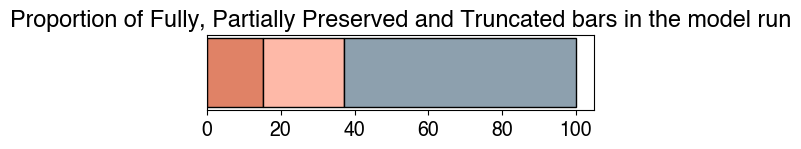

In [92]:
plt.figure(figsize = (5, 1), dpi = 100)
percfp = len(allbars[allbars['PreservChar']=='FP'])*100/len(allbars)
percpp = len(allbars[allbars['PreservChar']=='PP'])*100/len(allbars)
perctr = len(allbars[allbars['PreservChar']=='TR'])*100/len(allbars)
plt.barh(1,  percfp, color = pres_palette[0], edgecolor = 'k')
plt.barh(1,  percpp, left = percfp, color = pres_palette[1], edgecolor = 'k')
plt.barh(1,  perctr, left = percfp+percpp, color = pres_palette[2], edgecolor = 'k')

plt.title('Proportion of Fully, Partially Preserved and Truncated bars in the model run')
plt.yticks([])

## Box plots by preservation

In [9]:
## for boxplots, replacing all small depth values and velocities etc with NaNs

# ['I', 'J', 'X', 'Y', 'Depth(m)', 'Elevation(m)', 'ShearStress(Nm-2)', 'ElevationChange(m)', 'FroudeNumber', 'ShieldsNumber','Velocity(ms-1) (magnitude)', 'BedloadFlux(m2s-1) (magnitude)'])
depthresh = 0.1 ## threashold depth above which we consider aerially exposed
datamaster[:, 4, :][np.logical_or(datamaster[:, 4, :]<depthresh, datamaster[:, 4, :]>np.nanquantile(datamaster[:, 4, :], 0.9999))] = np.nan
datamaster[:, 6, :][np.logical_or(datamaster[:, 4, :]<depthresh, datamaster[:, 4, :]>np.nanquantile(datamaster[:, 4, :], 0.9999))] = np.nan
datamaster[:, 6, :][datamaster[:, 6, :]>10] = np.nan
datamaster[:, 10, :][np.logical_or(datamaster[:, 4, :]<depthresh, datamaster[:, 4, :]>np.nanquantile(datamaster[:, 4, :], 0.9999))] = np.nan


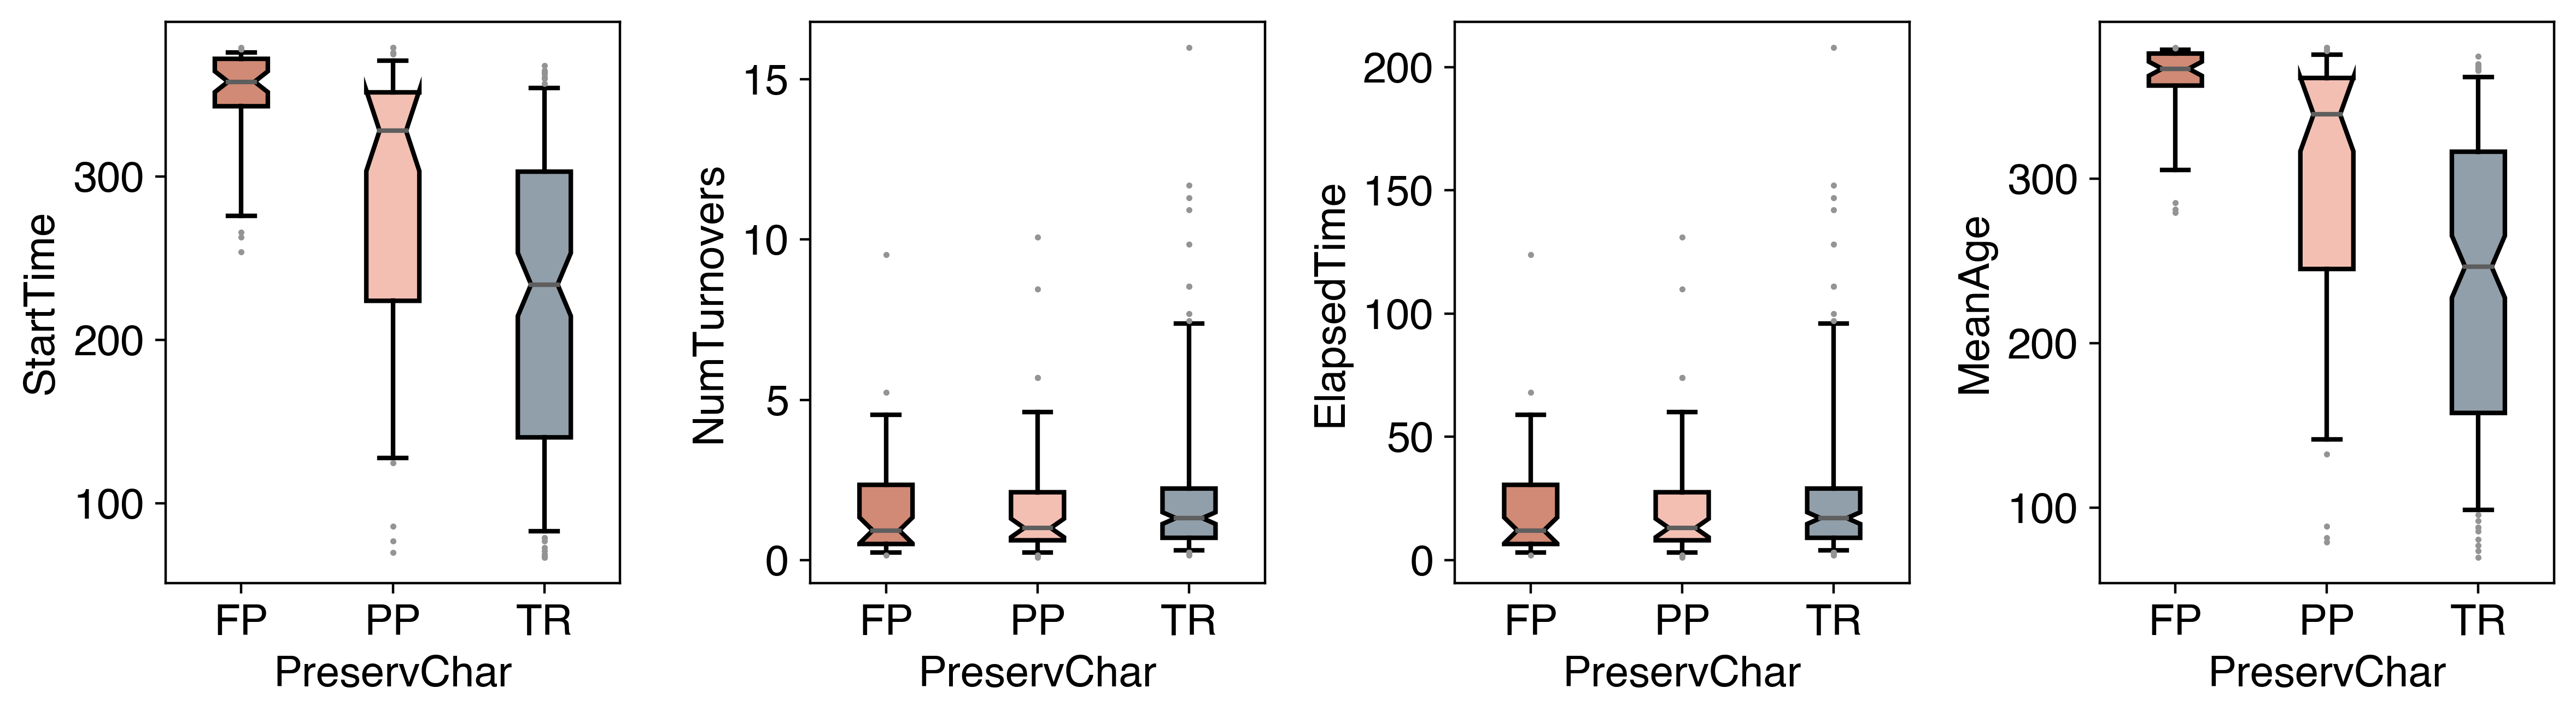

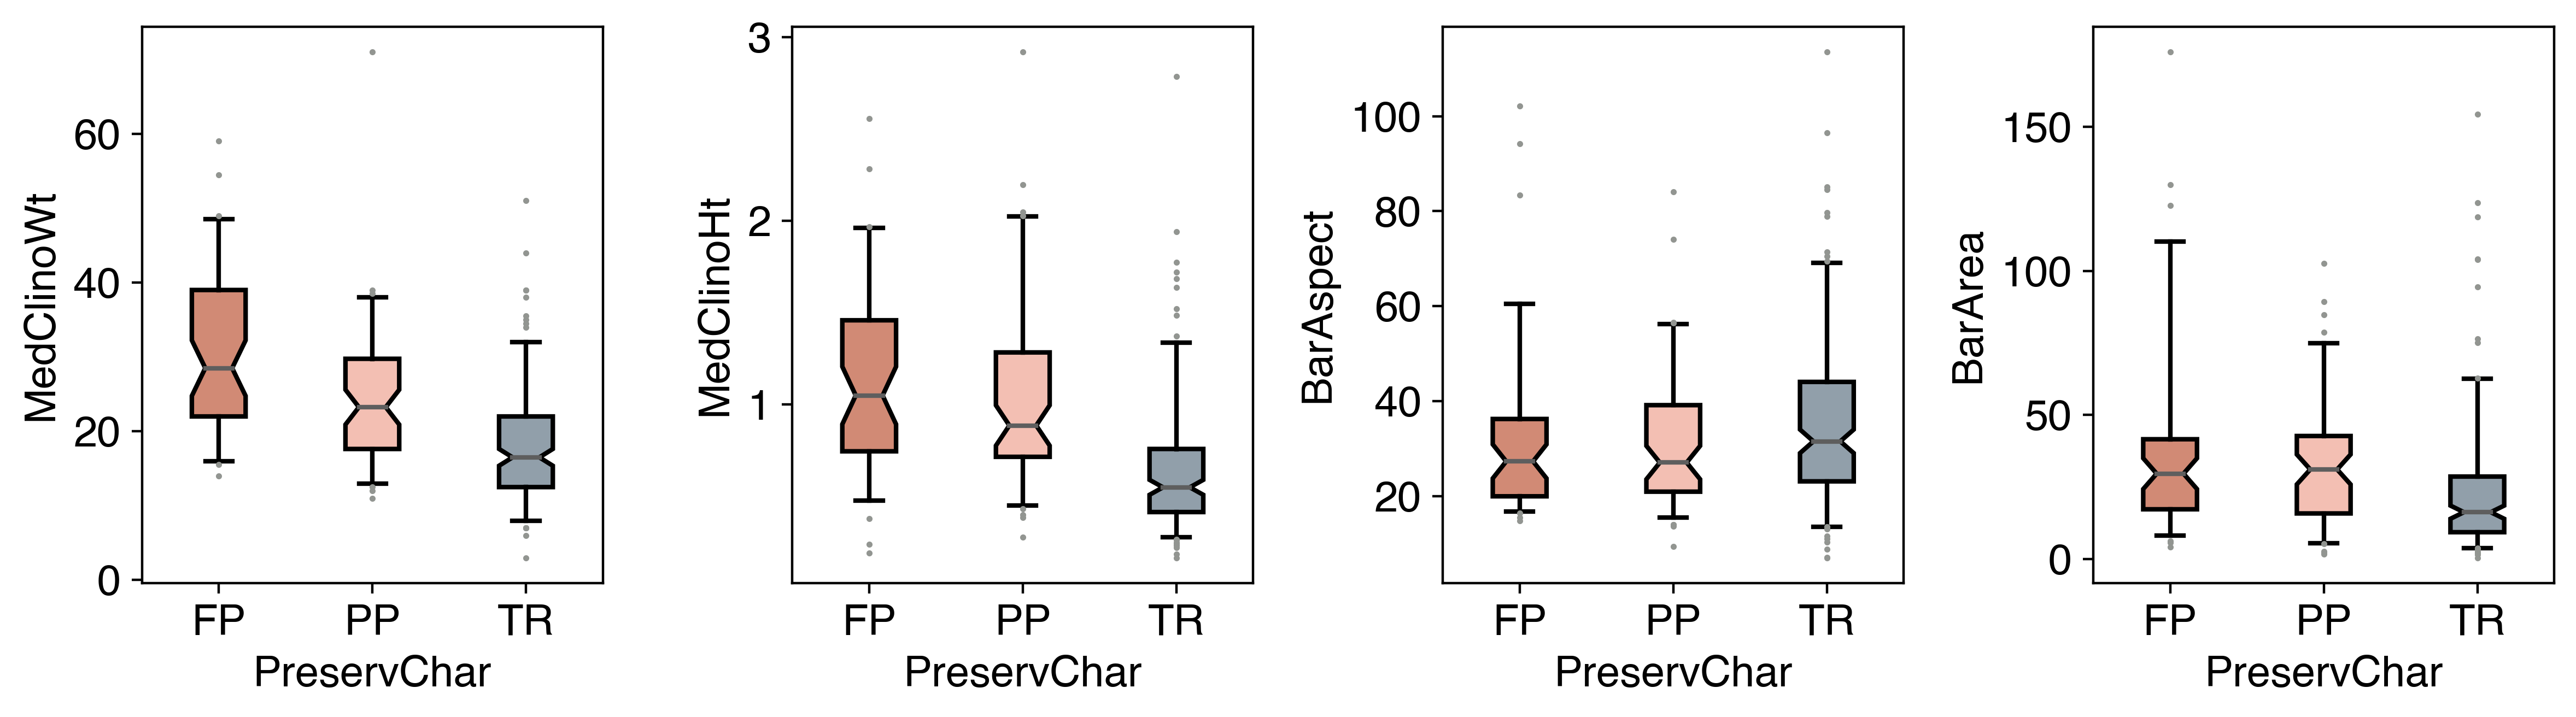

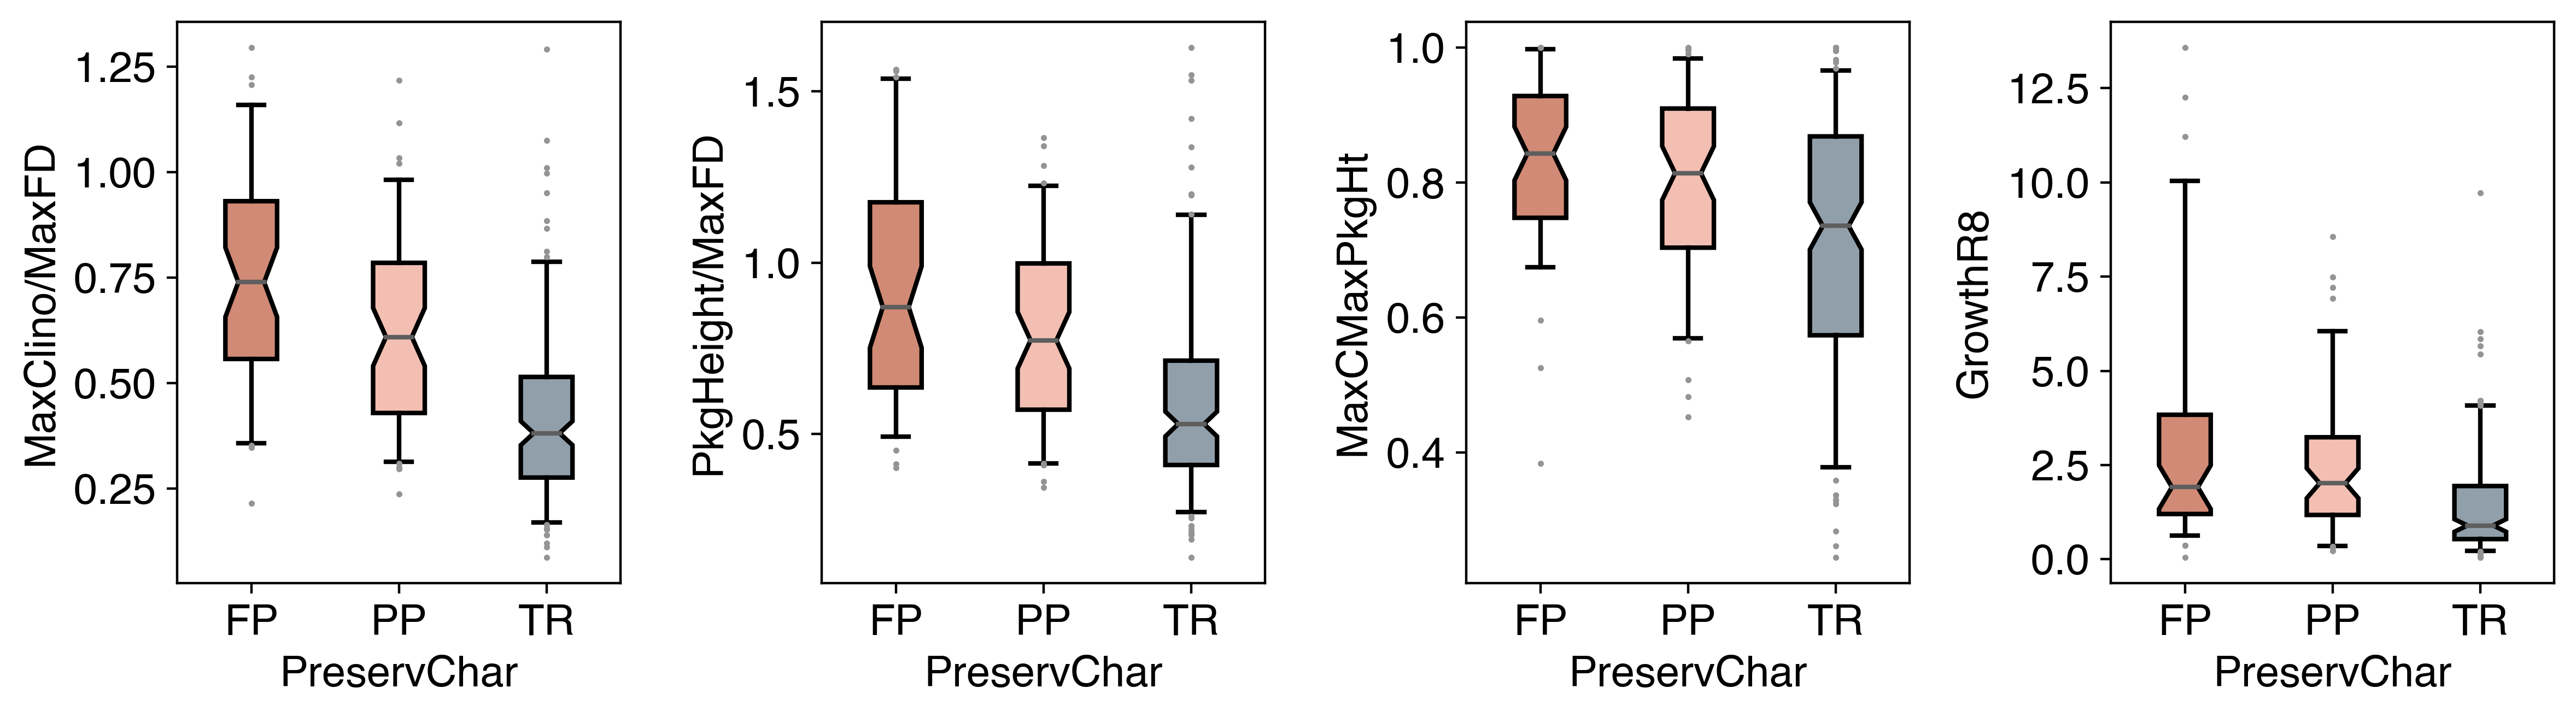

In [98]:
# hydraulic_vars = ['MeanFlowDepth', 'MaxFlowDepth', 'MaxVelocity', 'MaxShear']
geometric_vars = ['MedClinoWt', 'MedClinoHt', 'BarAspect', 'BarArea']
# diagnostics = ['MaxClino/MaxFD', 'MaxCMaxPkgHt', 'UBar', 'GrowthR8']
# agg_flags = ['PkgHeight/MedFD', 'PkgHeight/MeanFD', 'PkgHeight/MaxFD', 'MeanAge']

time = ['StartTime', 'NumTurnovers', 'ElapsedTime', 'MeanAge']
scalers = ['MaxClino/MaxFD', 'PkgHeight/MaxFD', 'MaxCMaxPkgHt', 'GrowthR8']

flierprops = dict(marker='.', markerfacecolor='xkcd:gray', markersize=2,  markeredgecolor='xkcd:gray')
boxprops = dict(edgecolor = 'k', linewidth = 1.5)
capprops = dict(color = 'k', linewidth = 1.5)
whiskerprops = dict(color = 'k')
boxwidth = 0.35
linewidth = 1.5

## PANEL 1————————————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(time), figsize = (12, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()

for i, a in enumerate(ax):
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = time[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel1.png', dpi = 400)

## PANEL 2————————————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(time), figsize = (12, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()

for i, a in enumerate(ax):
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = geometric_vars[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel2.png', dpi = 400)

## PANEL 3————————————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (12, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
               boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)
# ## PANEL 4————————————————————————————————————————————————————————————————————————————————————————————————

# fig, ax = plt.subplots(1, len(diagnostics), figsize = (12, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = diagnostics[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
#                boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)

# ax[3].set_ylim(0, 15)
# # plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel4.png', dpi = 400)

# ## PANEL 5————————————————————————————————————————————————————————————————————————————————————————————————

# fig, ax = plt.subplots(1, len(agg_flags), figsize = (12, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = agg_flags[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
#                boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)

# # ax[3].set_ylim(0, 15)
# # plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel4.png', dpi = 400)



### Box/Cross plots for paper

In [ ]:
agevars = ['StartTime', 'MeanAge', 'EndTime', 'ElapsedTime']
geometry = ['']

In [57]:
allbars.columns

Index(['BarName', 'array name', 'iloc', 'PreservChar', 'CoherenceVal',
       'StartTime', 'EndTime', 'ElapsedTime', 'LeftEdge', 'RightEdge',
       'BarWidth', 'BarHeight', 'BarAspect', 'BarArea', 'Section Area',
       'ChannelProp', 'Angle Skewness', 'Basal Surf Relief', 'Mean dzdx',
       'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt',
       'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt', 'ModeClinoWt',
       'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD', 'MaxClinoICD',
       'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
       'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth',
       'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear', 'ModeShear',
       'MeanShear', 'SDShear', 'MedShear', 'MinVelocity', 'MaxVelocity',
       'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
       'TRAINFLAG', 'notes', 'CVFlowDepth', 'CVVelocity', 'VarFlowDepth',
       'VarVelocity', 'Skew Abs', 'TempAgg', 

<Figure size 2000x2000 with 0 Axes>

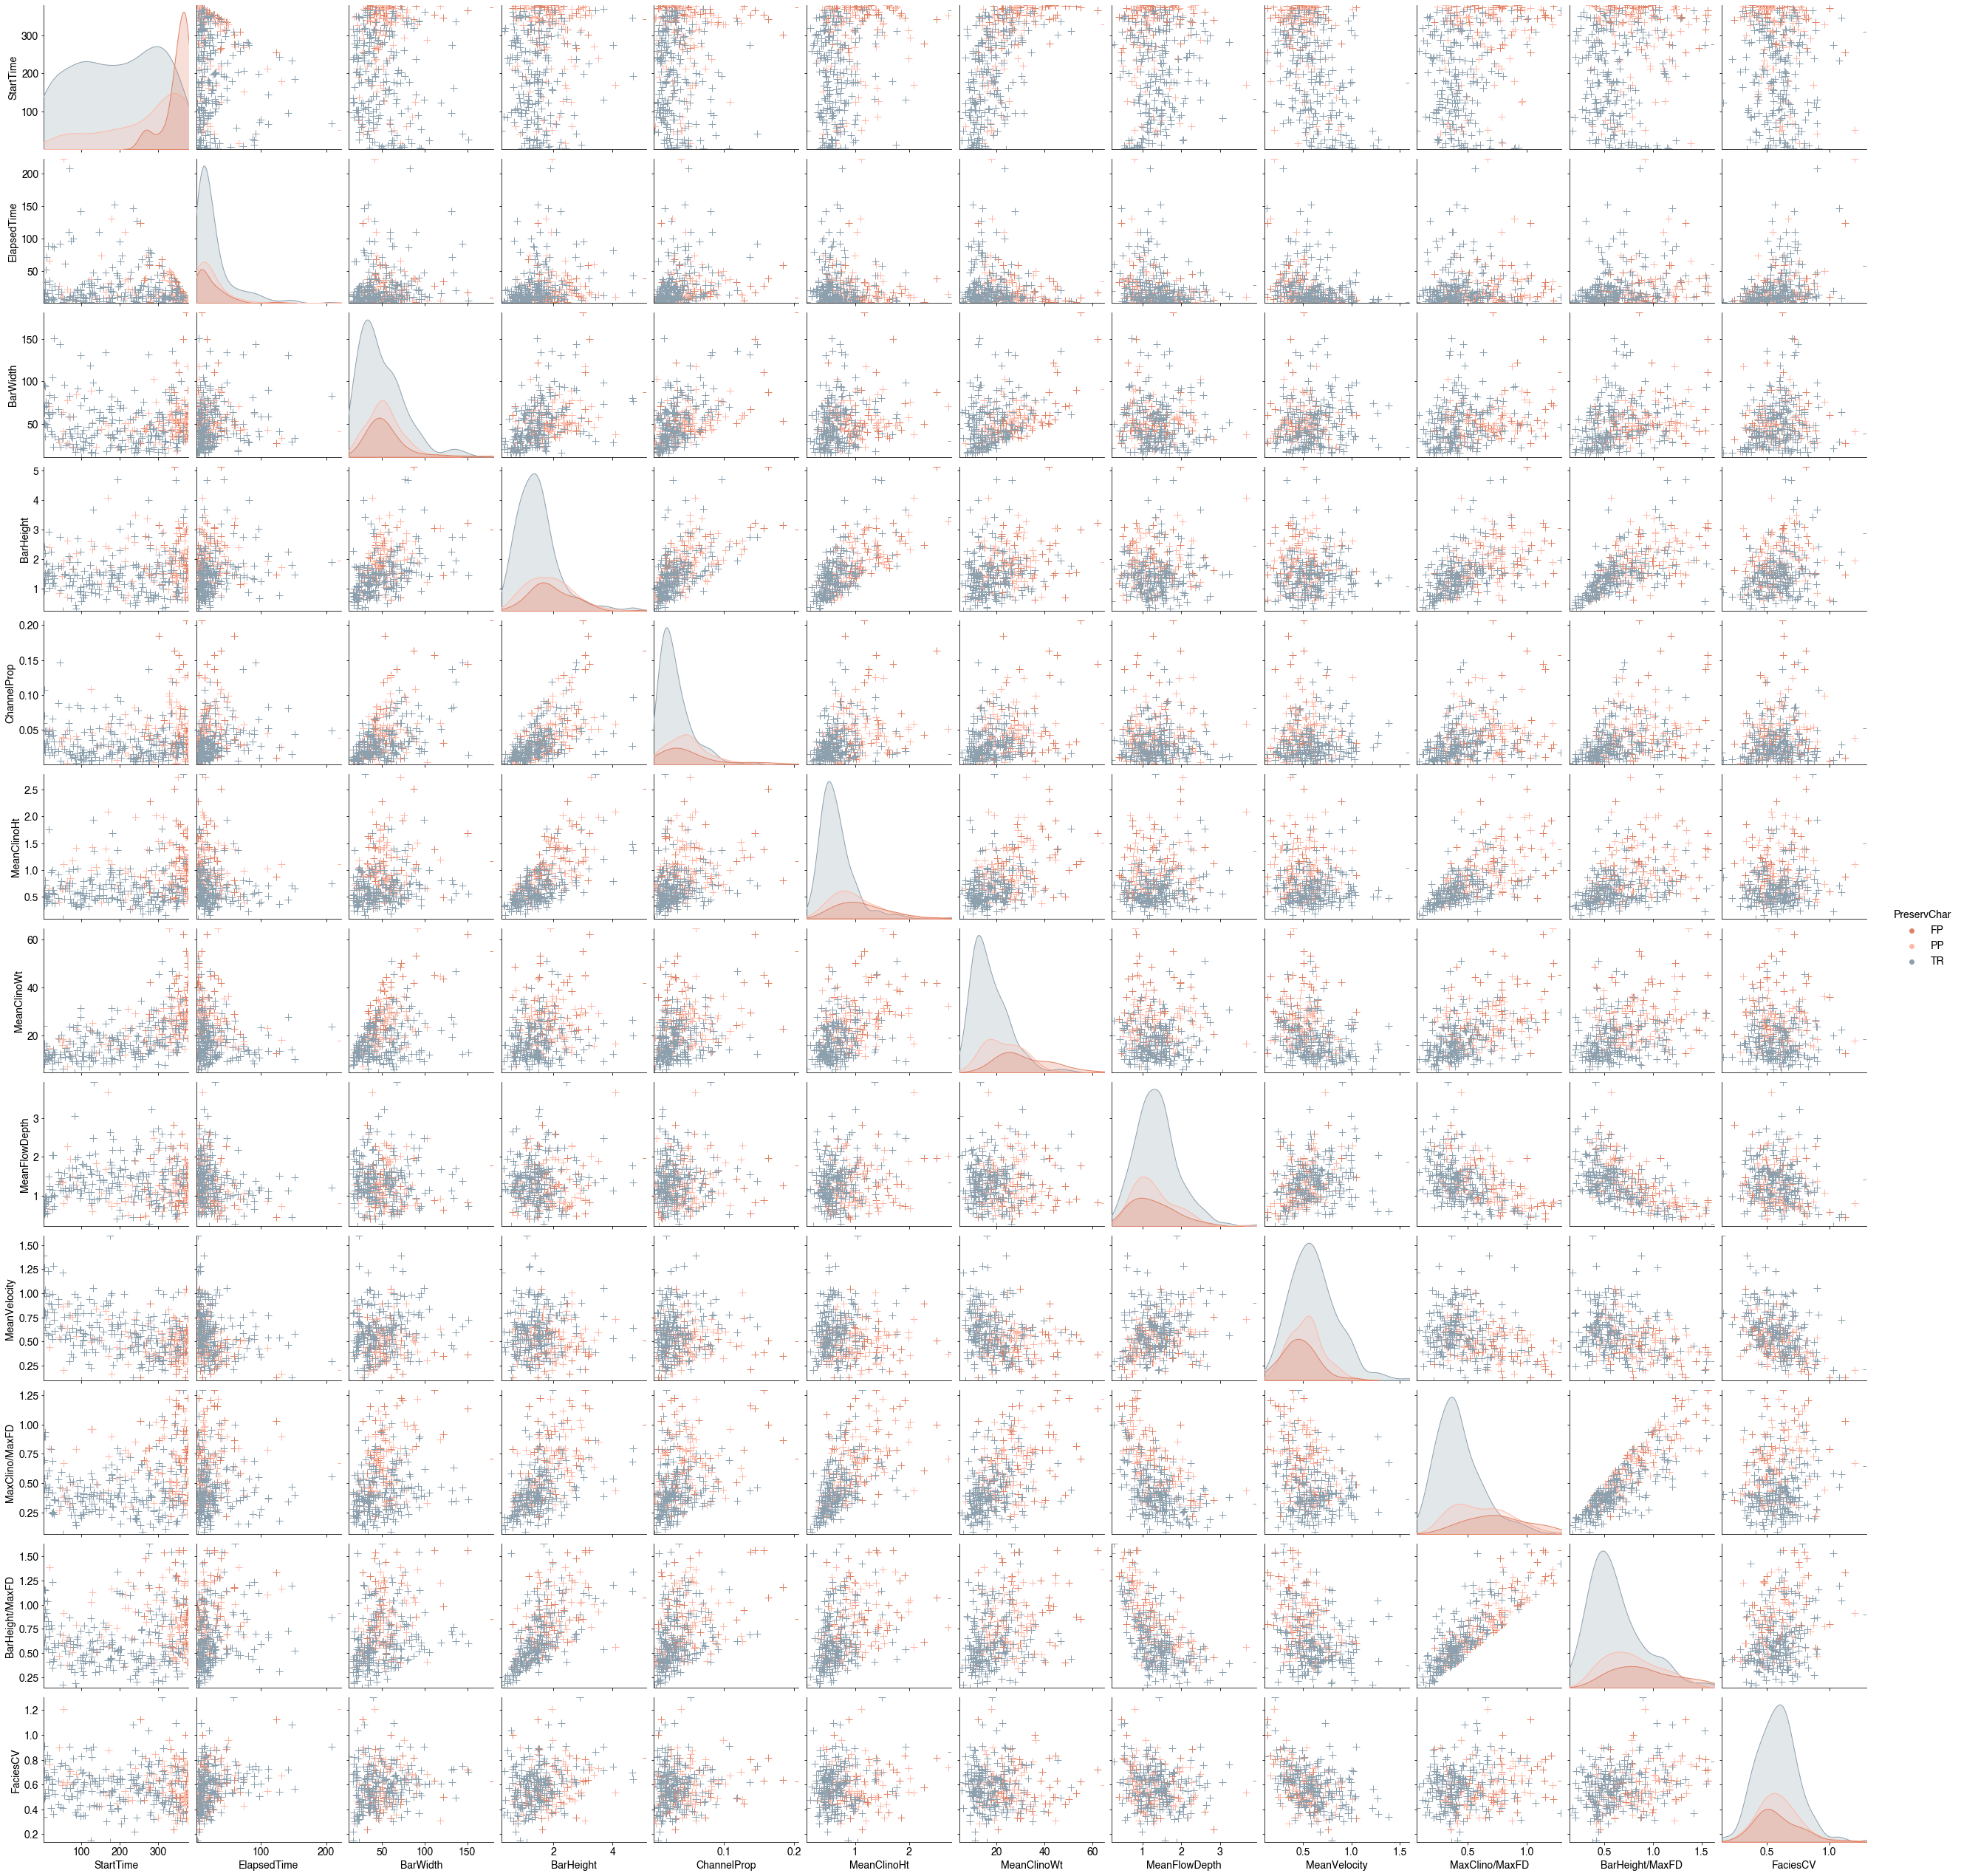

In [82]:
plt.figure(figsize = (20, 20), dpi = 100, tight_layout = True)
pplot = sns.pairplot(data=allbars, hue='PreservChar', palette=pres_palette, dropna=True,
             plot_kws=dict(marker = '+', linewidth=1, s = 100),
             vars=['StartTime', 'ElapsedTime', 'BarWidth', 'BarHeight', 'ChannelProp', 
                   'MeanClinoHt', 'MeanClinoWt', 'MeanFlowDepth', 'MeanVelocity', 'MaxClino/MaxFD',
                   'BarHeight/MaxFD', 'FaciesCV'],
             height = 3, aspect = 1)

snsvars=['StartTime', 'ElapsedTime', 'BarWidth', 'BarHeight', 'ChannelProp', 
                   'MeanClinoHt', 'MeanClinoWt', 'MeanFlowDepth', 'MeanVelocity', 'MaxClino/MaxFD',
                   'BarHeight/MaxFD', 'FaciesCV']
for i, v in enumerate(snsvars):
    pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))

for i, v in enumerate(snsvars):
    pplot.axes[i, 0].set(ylim=(allbars[v].min(), allbars[v].max()))


list_of_attribs = [
       'StartTime', 'CoherenceVal', 'ElapsedTime', 'BarWidth', 'BarHeight', 'BarAspect', 'BarArea',
       'ChannelProp', 'Angle Skewness', 'Basal Surf Relief',
       'Mean dzdx', 'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt',
       'MeanClinoHt', 'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt',
       'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD',
       'MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD',
       'MedClinoICD', 'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth',
       'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear',
       'ModeShear', 'MeanShear', 'SDShear', 'MedShear', 'MinVelocity',
       'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity',
       'MedVelocity', 'CVFlowDepth', 'CVVelocity',
       'Skew Abs', 'TempAgg', 'Skew Binned', 'Co Binned', 'BSR Binned',
       'MeanFacies', 'MedFacies', 'BarHeight/MaxFD',
       'MaxClino/MaxFD', 'MaxClino/MedFD', 'MedClino/MedFD', 'BFscaling',
       'BL/CL', 'ReconFlowDepth', 'UBar', 'mmpmean', 'FaciesCV', 'CVClinoWt']

<Figure size 1152x1152 with 0 Axes>

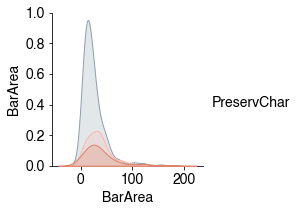

In [87]:
plt.figure(figsize = (16,16))
pplot = sns.pairplot(data=allbars, hue='PreservChar', palette=pres_palette, dropna=True,
             plot_kws=dict(marker = '+', linewidth=1, s = 100),
             vars=['BarArea'],
             height = 3, aspect = 1)

In [107]:
# fig, ax = plt.subplots(1, 3, figsize = (15, 5), dpi = 100, tight_layout = True, sharex = True, sharey = True)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='FP'], x = 'MedClinoWt', y = 'MedClinoHt', color = pres_palette[0], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=15), joint_kws=dict(bins=15))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='PP'], x = 'MedClinoWt', y = 'MedClinoHt', color = pres_palette[1], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=25), joint_kws=dict(bins=25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='TR'], x = 'MedClinoWt', y = 'MedClinoHt', color = pres_palette[2], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=25), joint_kws=dict(bins=25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

#### Number of turnover timescales vs bar size

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_11120/66003829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='FP'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[0], kind = 'hist',
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_11120/66003829.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='PP'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[1], kind = 'hist',
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_11120/66003829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='TR'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[2], kind = 'hex',


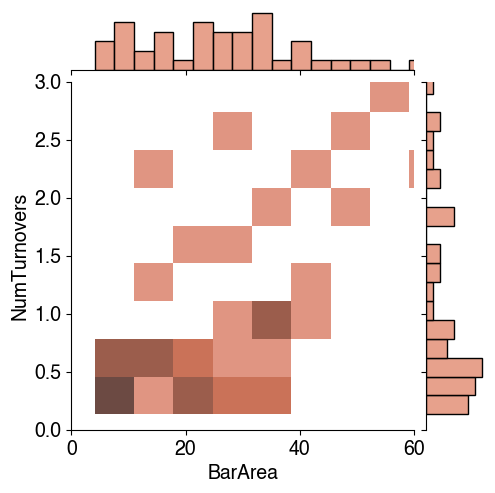

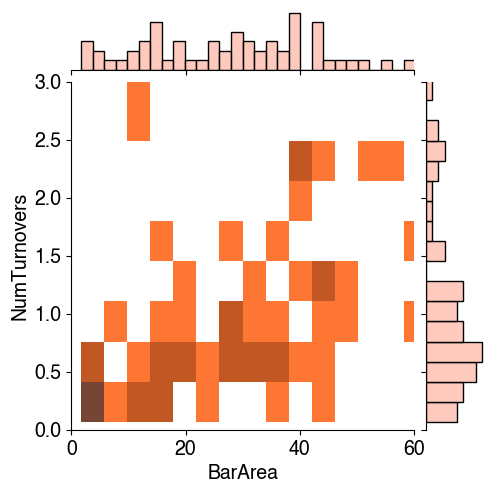

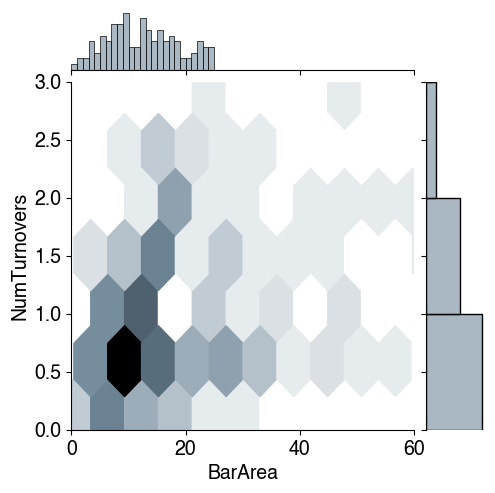

In [42]:
# fig, ax = plt.subplots(1, 3, figsize = (15, 5), dpi = 100, tight_layout = True, sharex = True, sharey = True)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='FP'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[0], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=50), joint_kws=dict(bins=25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='PP'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[1], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=50), joint_kws=dict(bins=25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='TR'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[2], kind = 'hex',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins = 25, binrange = [0, 25]), joint_kws=dict(bins = 25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

make cmaps for the histograms

In [111]:
# colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
colors = ['w', pres_palette[0]]
cmapred = mcol.LinearSegmentedColormap.from_list('mycmap', colors, N=2)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]



cmapblue = mcol.LinearSegmentedColormap.from_list('mycmap', colors, N=5)

/Applications/anaconda3/lib/python3.8/site-packages/matplotlib/colors.py:373: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rgba = np.array(c)


In [108]:
fpcmap = LinearSegmentedColormap.from_list("fpcmap", list(zip([0, 1], ['w', pres_palette[0]])))
# fpcmap[:,-1] = np.linspace(0, 1, fpcmap.N)
ppcmap = LinearSegmentedColormap.from_list("ppcmap", list(zip([0, 1], ['w', pres_palette[1]])))
trcmap = LinearSegmentedColormap.from_list("trcmap", list(zip([0, 1], ['w', pres_palette[2]])))

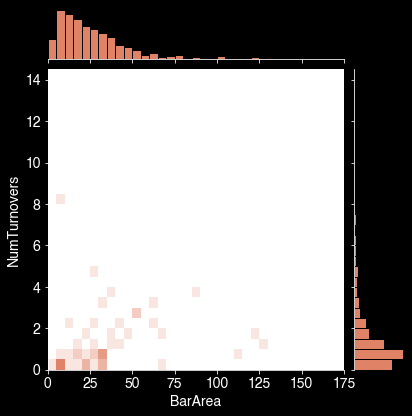

In [118]:
g = sns.JointGrid(x="BarArea", y="NumTurnovers", data=allbars[allbars['PreservChar']=='FP'])
g = g.plot_joint(plt.hist2d, bins = [np.arange(0, allbars['BarArea'].max(), 5), np.arange(0, allbars['NumTurnovers'].max(), 0.5)], density = True,
                 cmap = fpcmap, color="#e08266", edgecolor="k", linewidth = 0)

_ = g.ax_marg_x.hist(allbars["BarArea"], color=pres_palette[0], edgecolor = 'k', alpha=1,
                      bins=np.arange(0, allbars['BarArea'].max(), 5))
_ = g.ax_marg_y.hist(allbars["NumTurnovers"], color=pres_palette[0], edgecolor = 'k', alpha=1,
                      orientation="horizontal",
                      bins=np.arange(0, allbars['NumTurnovers'].max(), 0.5))
# ax = plt.gca()
# ax.set_xlim = (allbarsFP['BarArea'].min(), allbarsFP['BarArea'].max())
# ax.set_ylim = (allbarsFP['NumTurnovers'].min(), allbarsFP['NumTurnovers'].max())

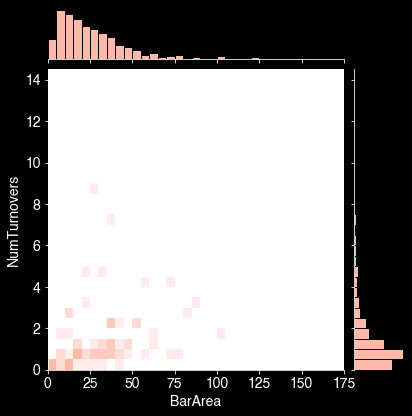

In [105]:
g = sns.JointGrid(x="BarArea", y="NumTurnovers", data=allbars[allbars['PreservChar']=='PP'])
g = g.plot_joint(plt.hist2d, bins = [np.arange(0, allbars['BarArea'].max(), 5), np.arange(0, allbars['NumTurnovers'].max(), 0.5)], density = True,
                 cmap = ppcmap, edgecolor="k", linewidth = 0)

_ = g.ax_marg_x.hist(allbars["BarArea"], color=pres_palette[1], edgecolor = 'k', alpha=1,
                      bins=np.arange(0, allbars['BarArea'].max(), 5))
_ = g.ax_marg_y.hist(allbars["NumTurnovers"], color=pres_palette[1], edgecolor = 'k', alpha=1,
                      orientation="horizontal",
                      bins=np.arange(0, allbars['NumTurnovers'].max(), 0.5))
# ax = plt.gca()
# ax.set_xlim = (allbarsFP['BarArea'].min(), allbarsFP['BarArea'].max())
# ax.set_ylim = (allbarsFP['NumTurnovers'].min(), allbarsFP['NumTurnovers'].max())

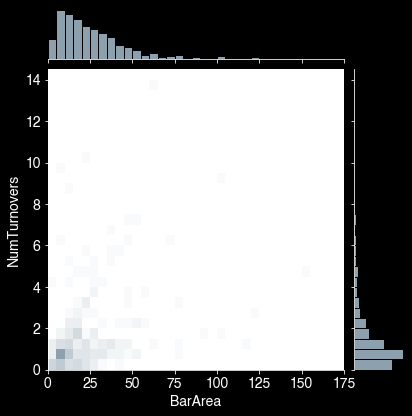

In [106]:
g = sns.JointGrid(x="BarArea", y="NumTurnovers", data=allbars[allbars['PreservChar']=='TR'])
g = g.plot_joint(plt.hist2d, bins = [np.arange(0, allbars['BarArea'].max(), 5), np.arange(0, allbars['NumTurnovers'].max(), 0.5)], density = True,
                 cmap = trcmap, edgecolor="k", linewidth = 0)

_ = g.ax_marg_x.hist(allbars["BarArea"], color=pres_palette[2], edgecolor = 'k', alpha=1,
                      bins=np.arange(0, allbars['BarArea'].max(), 5))
_ = g.ax_marg_y.hist(allbars["NumTurnovers"], color=pres_palette[2], edgecolor = 'k', alpha=1,
                      orientation="horizontal",
                      bins=np.arange(0, allbars['NumTurnovers'].max(), 0.5))

# ax.set_xlim = (allbarsFP['BarArea'].min(), allbarsFP['BarArea'].max())
# ax.set_ylim = (allbarsFP['NumTurnovers'].min(), allbarsFP['NumTurnovers'].max())

## Testing hypotheses from candidacy propsal:
1. Increased preservation in zones where the channel is widening
2. Wider, thinner packages at zones of thread splitting
3. More relief at zones where channel belt is widening

In [46]:
avg_wr = np.nanmean(total_wr_2h, axis = 1)
wideningzones = np.where(avg_wr>np.nanquantile(avg_wr, 0.5))[0]
widening10 = np.unique(np.round(wideningzones, -1))

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_56582/1592015117.py:1: RuntimeWarning: Mean of empty slice
  avg_wr = np.nanmean(total_wr_2h, axis = 1)


Text(0.5, 1.0, 'average widening along the channel, \n black lines = widening zones, red = 75th ptile widening')

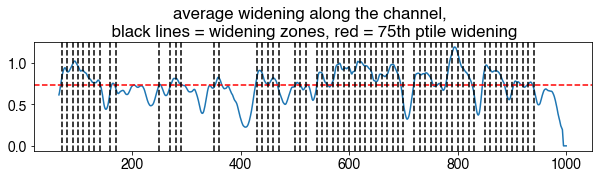

In [47]:
plt.figure(figsize = (10, 2))
plt.plot(avg_wr)
plt.axhline(np.nanquantile(avg_wr, 0.5), c = 'r', ls = '--')
for i in widening10:
    plt.axvline(i, c = 'k', ls = '--')
    
plt.title('average widening along the channel, \n black lines = widening zones, red = 75th ptile widening')

In [35]:
total_wr_2h.shape

(1001, 381)

In [36]:
wideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = wideningbars['iloc'].loc[row] in widening10
    # print(inarr)
    if inarr is False:
        wideningbars = wideningbars.drop([row])

notwideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = notwideningbars['iloc'].loc[row] in widening10
    # print(inarr)
    if inarr is True:
        notwideningbars = notwideningbars.drop([row])

    
# df.drop(df[(df.score < 50) & (df.score > 20)].index)

Text(0.5, 1.0, '<75th p Widening')

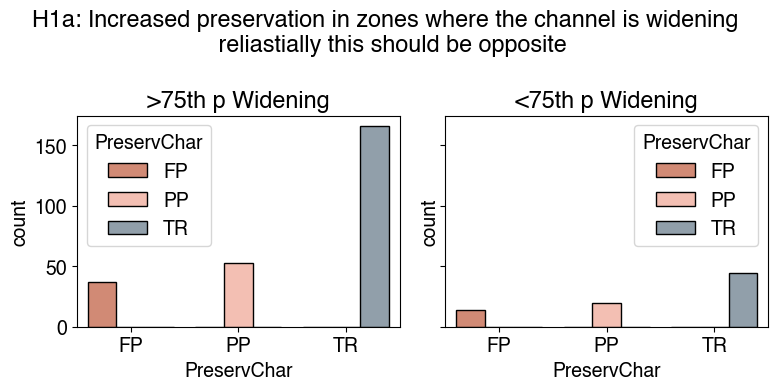

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4), tight_layout=True, sharey = True, dpi = 100)
sns.countplot(x = 'PreservChar', data = wideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[0], edgecolor = 'k')
sns.countplot(x = 'PreservChar', data = notwideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[1], edgecolor = 'k')
fig.suptitle('H1a: Increased preservation in zones where the channel is widening \n reliastially this should be opposite')
ax[0].set_title('>75th p Widening')
ax[1].set_title('<75th p Widening')

Text(0.5, 1.0, '<75th p Widening')

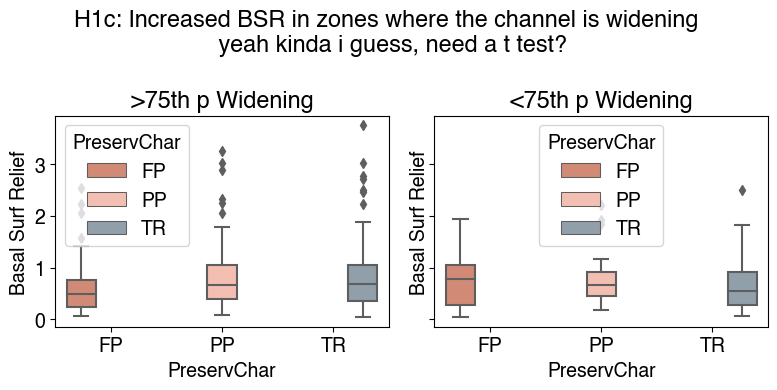

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4), tight_layout=True, sharey = True, dpi= 100)
sns.boxplot(x = 'PreservChar', y = 'Basal Surf Relief', data = wideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[0])#, edgecolor = 'k')
sns.boxplot(x = 'PreservChar', y = 'Basal Surf Relief', data = notwideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[1])#, edgecolor = 'k')
fig.suptitle('H1c: Increased BSR in zones where the channel is widening \n yeah kinda i guess, need a t test?')
ax[0].set_title('>75th p Widening')
ax[1].set_title('<75th p Widening')

## Compare between sections
### Proportion (skyscraper) plot, make sure sort is FP, PP, TR

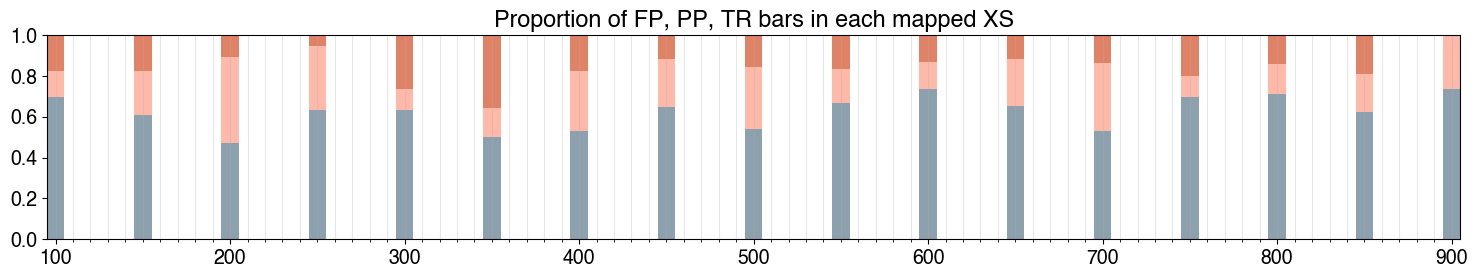

In [100]:
activech_mode = stats.mode(active_channels, axis = 1)[0]
pres_frequencies = np.empty([4, len(np.unique(allbars['iloc']))])
pres_frequencies[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 10

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    totalbars = len(subsample)
    pres_frequencies[1, idx] = len(subsample[subsample['PreservChar']=='FP'])/totalbars
    pres_frequencies[2, idx] = len(subsample[subsample['PreservChar']=='PP'])/totalbars
    pres_frequencies[3, idx] = len(subsample[subsample['PreservChar']=='TR'])/totalbars

    plt.bar(i, pres_frequencies[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_frequencies[2, idx], w, bottom = pres_frequencies[3, idx], color = pres_cols[1])
    plt.bar(i, pres_frequencies[1, idx], w, bottom = np.sum(pres_frequencies[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis = 'x', which = 'both', alpha = 0.3)

plt.savefig('/Users/safiya/Desktop/skyscrapercompare.png', transparent = True)
# plt.xlabel('Streamwise distance, m')
# plt.ylabel('Bar proportion')

# ax = plt.gca()
# ax1 = ax.twinx()
# # ax1.plot(avg_wr, 'k-')
# # ax1.axhline(np.quantile(avg_wr, 0.5), c = 'k', ls = '--', alpha = 0.5)
# # ax1.set_ylabel('Average widening rate')

# ax1.fill_between(np.arange(0, len(active_channels)), active_channels.min(axis = 1), active_channels.max(axis = 1), alpha = 0.1, color = 'k')
# plt.plot(activech_mode, 'k-')
# # plt.fill_between(np.arange(0, len(total_wr_2h))*10, total_wr_2h.min(axis = 1), total_wr_2h.max(axis = 1), alpha = 0.1, color = 'k')

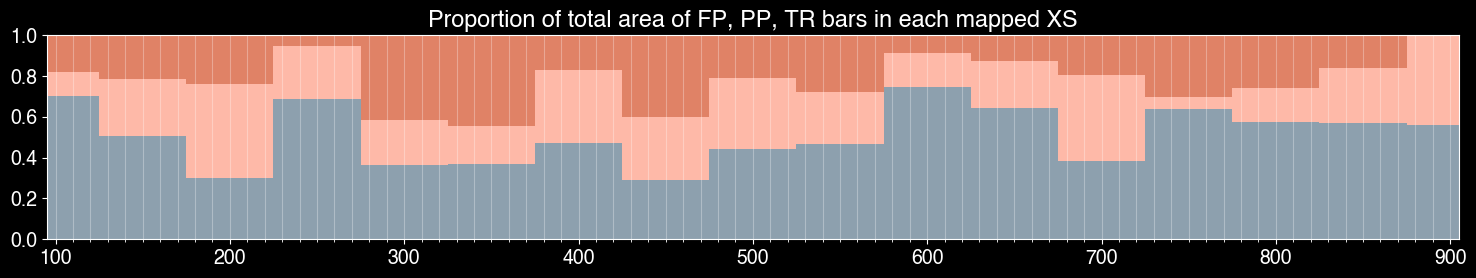

In [176]:
pres_area = np.empty([4, len(np.unique(allbars['iloc']))])
pres_area[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 10

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    chanarea = subsample['Section Area'].iloc[0]
    propmapped = sum(subsample['ChannelProp'])
#     pres_area[1, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='FP'])/chanarea
#     pres_area[2, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='PP'])/chanarea
#     pres_area[3, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='TR'])/chanarea
    
    ## Using only channel proportion
    pres_area[1, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='FP'])/propmapped
    pres_area[2, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='PP'])/propmapped
    pres_area[3, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='TR'])/propmapped

    plt.bar(i, pres_area[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_area[2, idx], w, bottom = pres_area[3, idx], color = pres_cols[1])
    plt.bar(i, pres_area[1, idx], w, bottom = np.sum(pres_area[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of total area of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis = 'x', which = 'both', alpha = 0.3)

In [44]:
allbars['AreaovTime'] = allbars['BarArea']/allbars['ElapsedTime']

(0.0, 10.0)

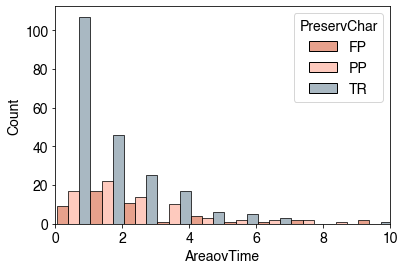

In [45]:
sns.histplot(x = 'AreaovTime', data = allbars, hue = 'PreservChar', palette = pres_palette, multiple = 'dodge', binwidth = 1)
plt.xlim(0, 10)

[None]

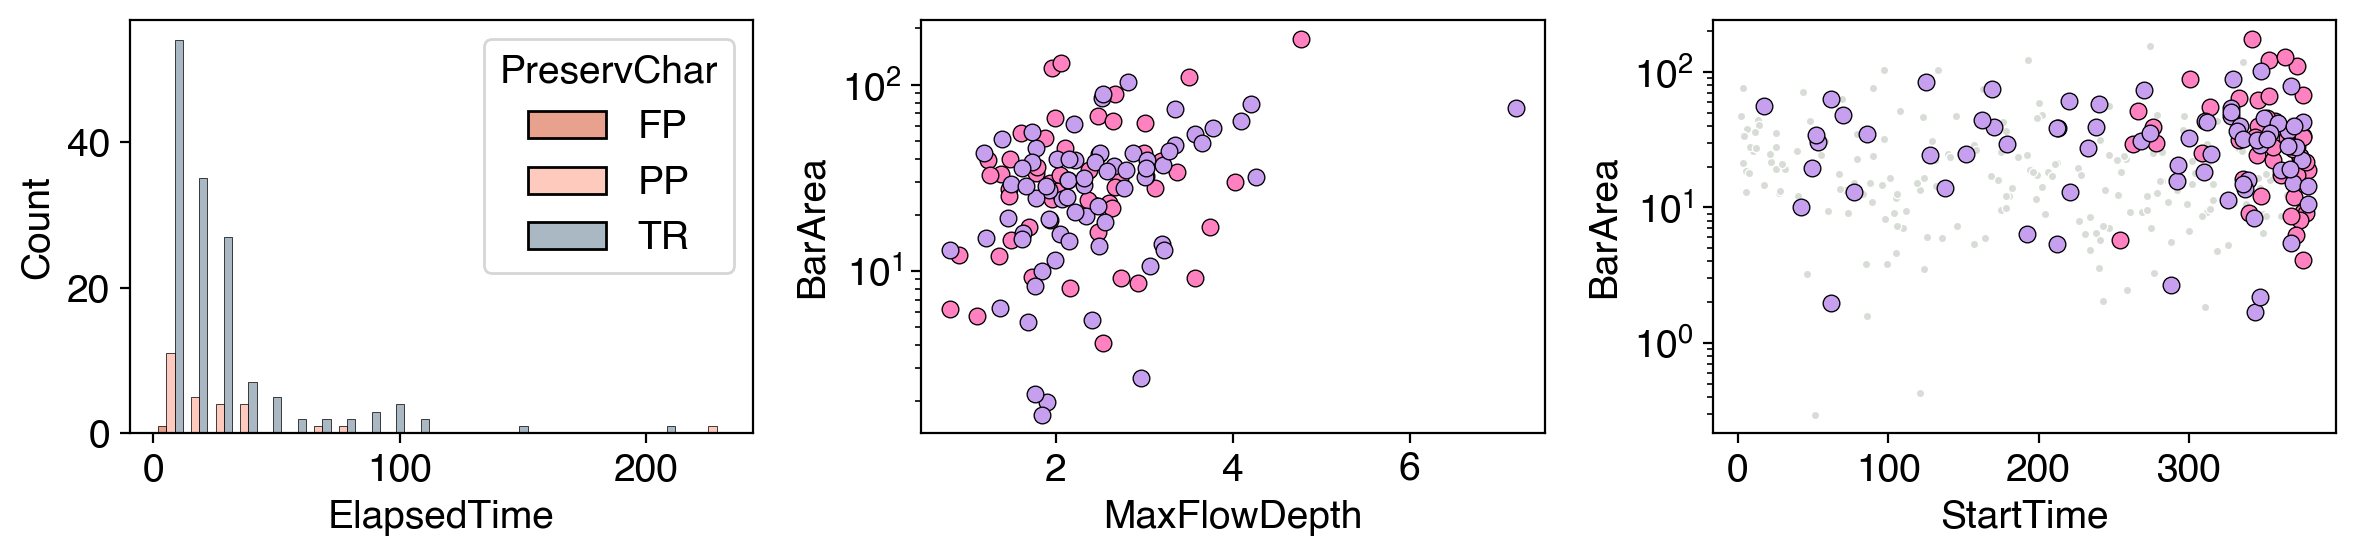

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi = 200, tight_layout = True)
sns.histplot(x = 'ElapsedTime', data = allbars[allbars['EndTime']<300], hue = 'PreservChar', palette = pres_palette, multiple = 'dodge', ax = ax[0], binwidth = 10)
# sns.histplot(x = 'ElapsedTime', data = allbars, hue = 'PreservChar', palette = pres_palette, multiple = 'stack', ax = ax[1], binwidth = 10)
timeplot = sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='TR'], ax = ax[2], c = ['xkcd:light grey'], marker = '.')
sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='FP'], ax = ax[2], edgecolor = 'k', c = ['xkcd:pink'])
sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='PP'], ax = ax[2], edgecolor = 'k', c = ['xkcd:lavender'])

# sns.scatterplot(x = 'MaxFlowDepth', y = 'BarArea', data = allbars[allbars['PreservChar']=='TR'], ax = ax[1], c = ['xkcd:light grey'], marker = '.')
sizeplot = sns.scatterplot(x = 'MaxFlowDepth', y = 'BarArea', data = allbars[allbars['PreservChar']=='FP'], ax = ax[1], edgecolor = 'k', c = ['xkcd:pink'])#, size = 'ElapsedTime')
sizeplot = sns.scatterplot(x = 'MaxFlowDepth', y = 'BarArea', data = allbars[allbars['PreservChar']=='PP'], ax = ax[1], edgecolor = 'k', c = ['xkcd:lavender'])#, size = 'ElapsedTime')
# sizeplot.set(xscale = 'log')
sizeplot.set(yscale = 'log')
timeplot.set(yscale = 'log')



<AxesSubplot:xlabel='BarArea', ylabel='Density'>

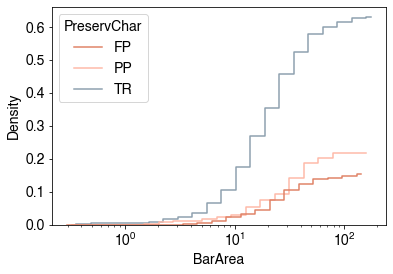

In [23]:
sns.histplot(data = allbars, x='BarArea', hue = 'PreservChar', palette = pres_palette, multiple = 'dodge', cumulative=True, element='step', fill=False, log_scale=True, stat='density')

### Box plots of each section

In [49]:
np.mean(wetwidthdf_mapped, axis = 0)

NameError: name 'wetwidthdf_mapped' is not defined

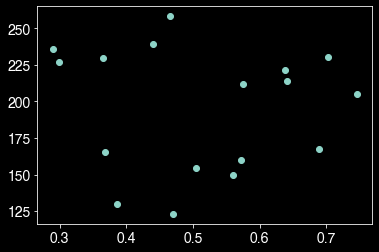

In [214]:
plt.scatter(pres_area[3, :], stats.mode(wetwidthdf_mapped.iloc[adjustment_time:, :], axis = 0)[0])

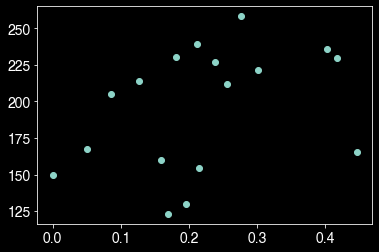

In [215]:
plt.scatter(pres_area[1, :], stats.mode(wetwidthdf_mapped.iloc[adjustment_time:, :], axis = 0)[0])

ValueError: Could not interpret input 'MaxClino/MaxFD'

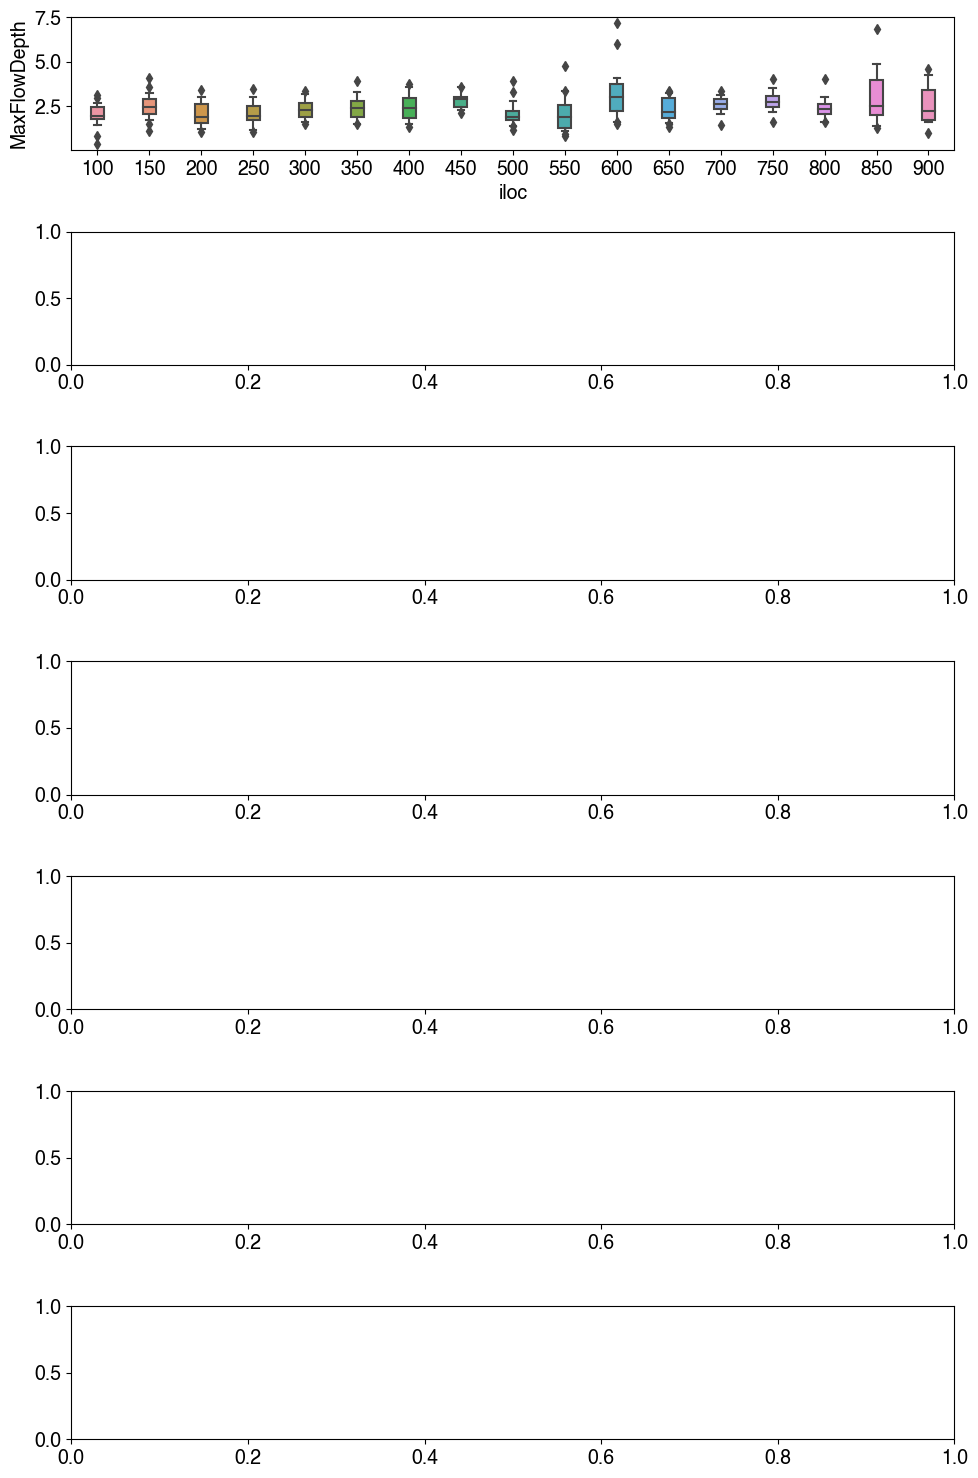

In [53]:
fig, ax = plt.subplots(7, 1, figsize = (10, 15), dpi = 100, tight_layout = True)
sns.boxplot(x = allbars['iloc'], y = allbars['MaxFlowDepth'], width = 0.25, whis = (5, 95), ax = ax[0])
sns.boxplot(data = allbars, x = 'iloc', y = 'MaxClino/MaxFD', width = 0.25, whis = (5, 95), ax = ax[1])
sns.boxplot(data = allbars, x = 'iloc', y = 'PkgHeight/MaxFD', width = 0.25, whis = (5, 95), ax = ax[2])
sns.boxplot(data = allbars, x = 'iloc', y = 'MaxCMaxPkgHt', width = 0.25, whis = (5, 95), ax = ax[3])
sns.boxplot(data = allbars, x = 'iloc', y = 'MeanShear', width = 0.25, whis = (5, 95), ax = ax[4], showfliers=False)
sns.boxplot(data = wetwidthdf_mapped, whis = (5, 95), width = .25, ax = ax[5])
sns.boxplot(data = threaddf_mapped, whis = (5, 95), width = .25, ax = ax[6])

# ax[0].hlines(np.quantile(datamaster[adjustment_time:, 4, :], [0.05, .95]), xmin = 0, xmax = 10)
ax[0].axhline(np.quantile(datamaster[adjustment_time:, 4, :], [.99]), c = 'b', ls = '--')

## Channel kinematics (threadiness and wetted width statistics)
### box plots of wetted width and number of active channels

In [44]:
(threaddf.iloc[:, ::50]).iloc[:, 2:-2]

NameError: name 'threaddf' is not defined

In [51]:
active_idx = np.concatenate((np.reshape(np.arange(0, 10010, 10), (active_channels.shape[0], 1)), active_channels), axis = 1)
threaddf = pd.DataFrame(active_channels.T)
# threaddf.columns = threaddf.iloc[0] ## put all the active channel data in a df
threaddf_mapped = deepcopy(threaddf.iloc[:, ::50]).iloc[:, 2:-2]

In [50]:
# wetwid_idx = np.concatenate((np.reshape(np.arange(0, 10010, 10), (active_channels.shape[0], 1)), active_channels), axis = 1)
wetwidthdf = pd.DataFrame(wetted_width.T)
# threaddf.columns = threaddf.iloc[0] ## put all the active channel data in a df
wetwidthdf_mapped = deepcopy(wetwidthdf.iloc[:, ::50]).iloc[:, 2:-2]

Text(0.5, 1.0, 'Wetted width')

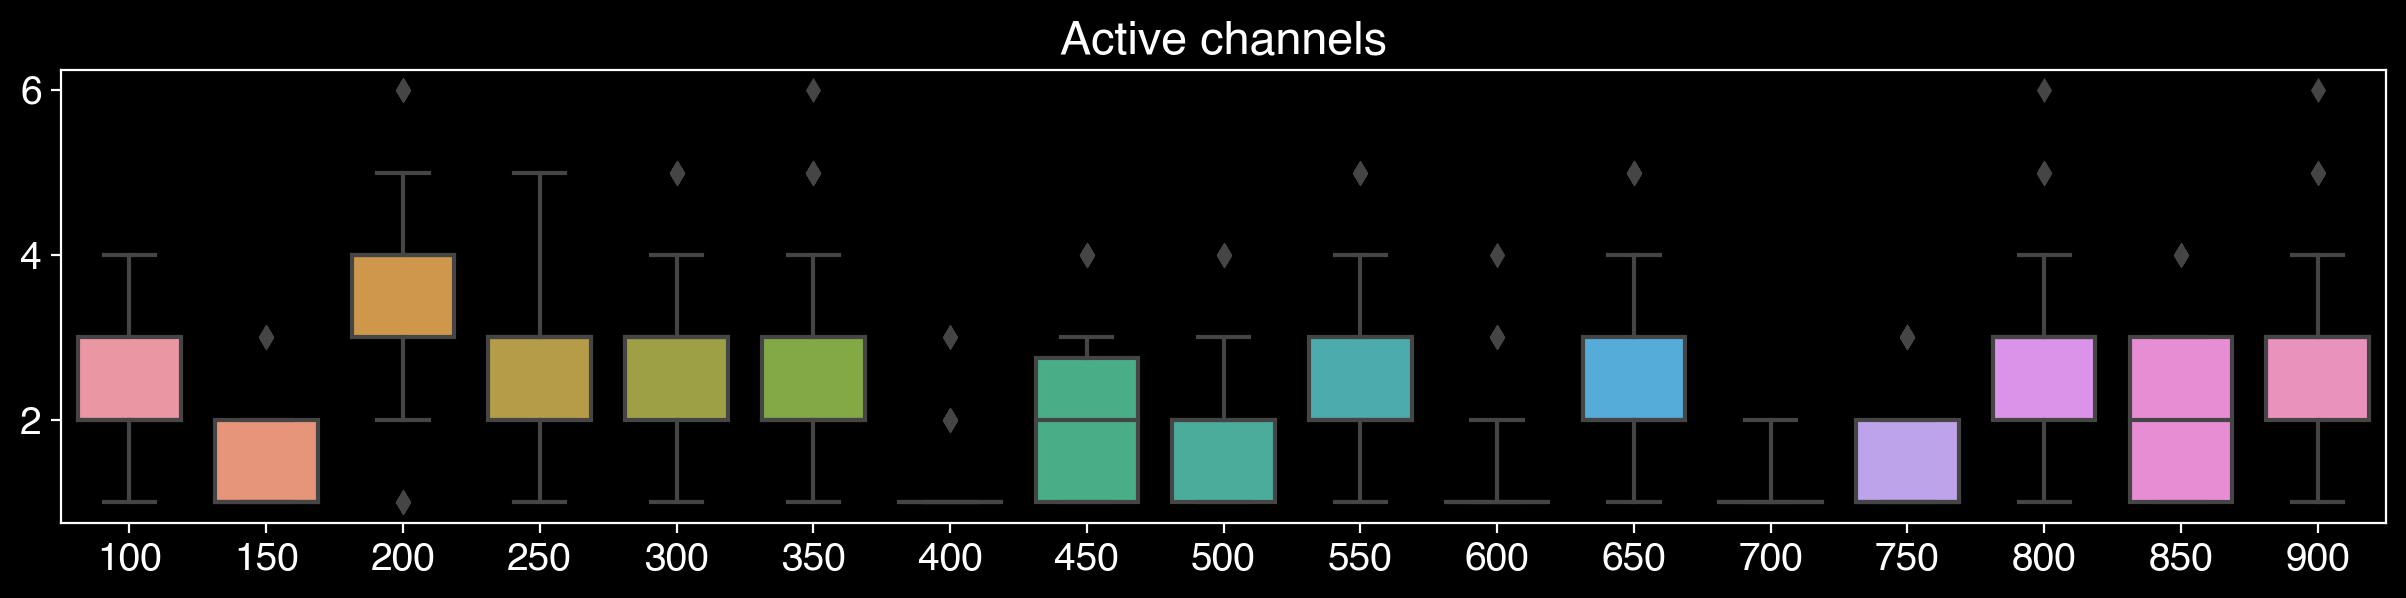

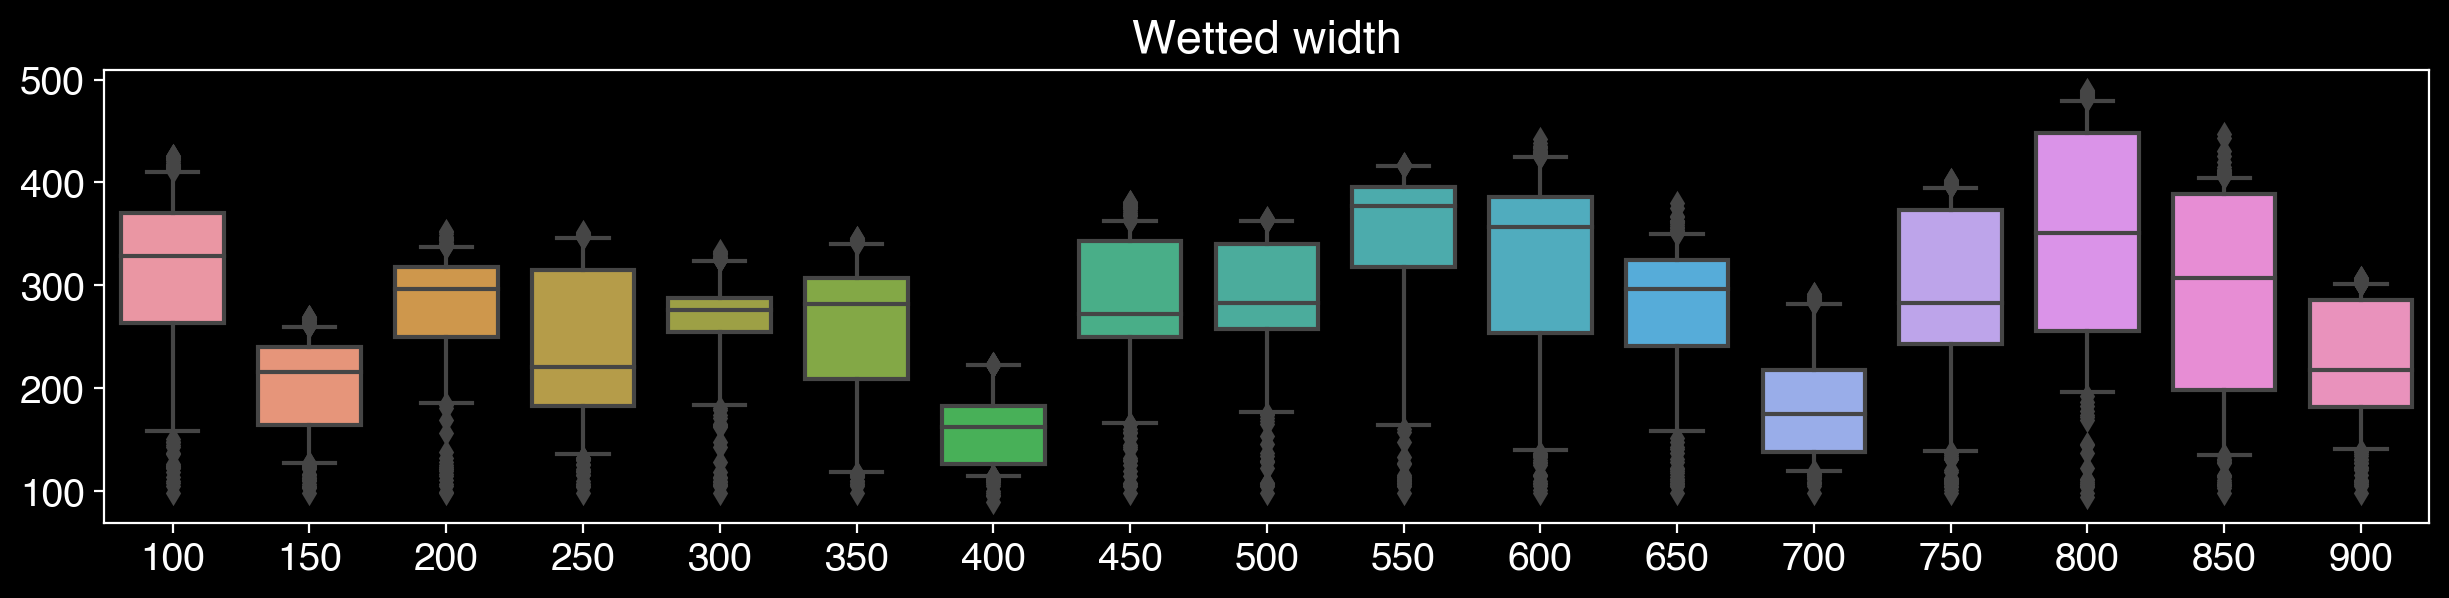

In [139]:
plt.figure(figsize = (15, 3), dpi = 200)
sns.boxplot(data = threaddf_mapped, whis = (5, 95), width = .75)
plt.title('Active channels')
plt.figure(figsize = (15, 3), dpi = 200)
sns.boxplot(data = wetwidthdf_mapped, whis = (5, 95), width = .75)
plt.title('Wetted width')

In [52]:
ww_thread = wetwidthdf_mapped/threaddf_mapped

In [79]:
stats.variation(threaddf_mapped, axis = 0)

array([0.37000425, 0.38867753, 0.24794342, 0.40690963, 0.29879559,
       0.46625341, 0.23510636, 0.41860821, 0.42763024, 0.39718569,
       0.39507719, 0.40888542, 0.34091745, 0.42438308, 0.42788271,
       0.42178107, 0.30572526])

Text(0, 0.5, 'SD threads')

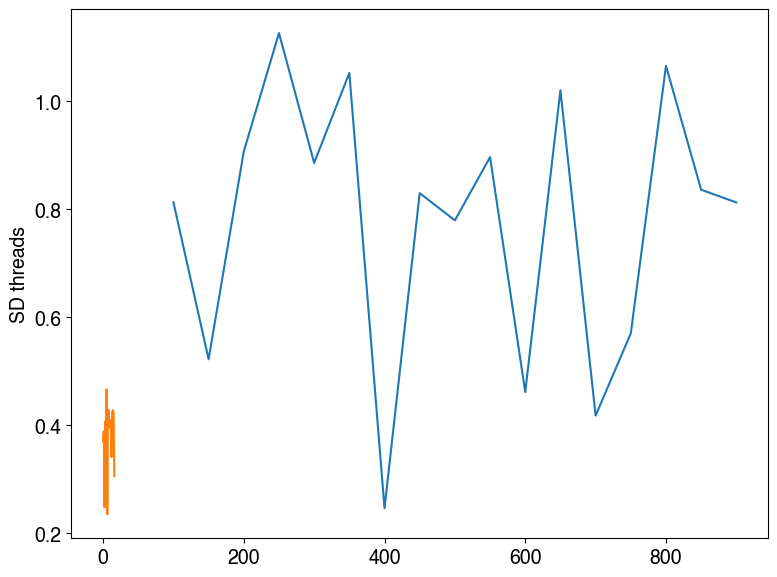

In [78]:
plt.figure(figsize = (8,6), tight_layout = True, dpi = 100)
plt.plot(np.std(threaddf_mapped, axis = 0), label = 'num threads')
plt.plot(stats.variation(threaddf_mapped, axis = 0), label = 'num threads')
# ax = plt.gca()
# ax1 = ax.twinx()
# ax1.plot(np.std(wetwidthdf_mapped, axis = 0), label = 'wetted width', ls = '--')
# ax1.set_ylabel('Standard deviation, WW')
plt.ylabel('SD threads')


Text(0, 0.5, 'WW/Num threads')

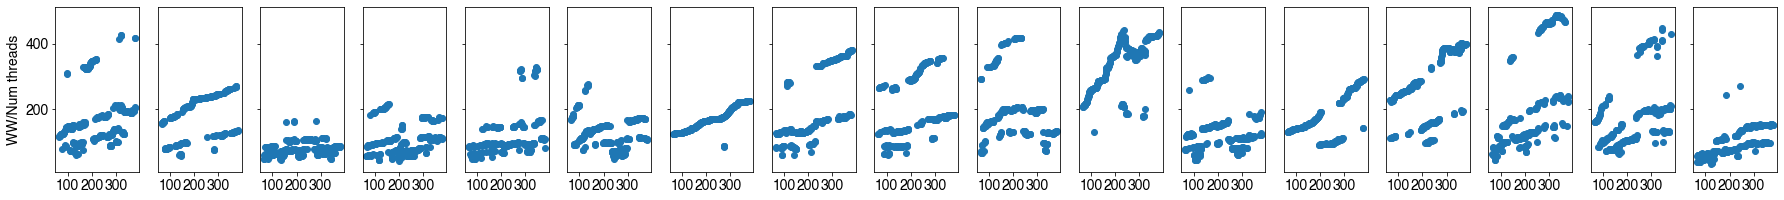

In [68]:
fig, ax = plt.subplots(1, 17, figsize = (25, 3), sharex = True, sharey = True, tight_layout = True)
for i in range(ww_thread.shape[1]):
    ax[i].scatter(np.arange(adjustment_time, ww_thread.shape[0]), ww_thread.iloc[adjustment_time:, i])
ax[0].set_ylabel('WW/Num threads')    

Looking at number of active threads during and following deposition of bars.

In [272]:
wideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = wideningbars['iloc'].loc[row] in widening10
    if inarr is False:
        wideningbars = wideningbars.drop([row])

notwideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = notwideningbars['iloc'].loc[row] in widening10
    if inarr is True:
        notwideningbars = notwideningbars.drop([row])


In [273]:
## find what these represent 
countfp = len(allbars[allbars['PreservChar']=='FP'])
countpp = len(allbars[allbars['PreservChar']=='PP'])
counttr = len(allbars[allbars['PreservChar']=='TR'])

propwidening_fp = len(wideningbars[wideningbars['PreservChar']=='FP'])/countfp
propwidening_pp = len(wideningbars[wideningbars['PreservChar']=='PP'])/countpp
propwidening_tr = len(wideningbars[wideningbars['PreservChar']=='TR'])/counttr

propnotwidening_fp = len(notwideningbars[notwideningbars['PreservChar']=='FP'])/countfp
propnotwidening_pp = len(notwideningbars[notwideningbars['PreservChar']=='PP'])/countpp
propnotwidening_tr = len(notwideningbars[notwideningbars['PreservChar']=='TR'])/counttr

In [274]:
print(f'Fully preserved in widening reach vs not widening: {np.round(propwidening_fp, 2)}, {np.round(propnotwidening_fp, 2)}')
print(f'Partially preserved in widening reach vs not widening: {np.round(propwidening_pp, 2)}, {np.round(propnotwidening_pp, 2)}')
print(f'Truncated in widening reach vs not widening: {np.round(propwidening_tr, 2)}, {np.round(propnotwidening_tr, 2)}')

Fully preserved in widening reach vs not widening: 0.68, 0.32
Partially preserved in widening reach vs not widening: 0.7, 0.3
Truncated in widening reach vs not widening: 0.67, 0.33


Looking at number of active threads during and following deposition of bars.

In [46]:
allbars['ActiveDuring'] = np.nan
allbars['ActiveAfter'] = np.nan
allbars['ActiveCV'] = np.nan
allbars['AfterCV'] = np.nan

for idx, dat in enumerate(zip(allbars['iloc'], allbars['StartTime'], allbars['EndTime'])):
    xs = dat[0]
    st = dat[1]
    en = dat[2]
    activesubset = threaddf_mapped[xs].iloc[st:en+1]
    aftersubset = threaddf_mapped[xs].iloc[en:]
    
    allbars['ActiveDuring'].iloc[idx] = stats.mode(activesubset, nan_policy = 'omit')[0]
    allbars['ActiveAfter'].iloc[idx] = stats.mode(aftersubset, nan_policy = 'omit')[0]
    allbars['ActiveCV'].iloc[idx] = stats.variation(activesubset, nan_policy = 'omit')
    allbars['AfterCV'].iloc[idx] = stats.variation(aftersubset, nan_policy = 'omit')

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_491/2610827434.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allbars['ActiveDuring'].iloc[idx] = stats.mode(activesubset, nan_policy = 'omit')[0]
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_491/2610827434.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allbars['ActiveAfter'].iloc[idx] = stats.mode(aftersubset, nan_policy = 'omit')[0]
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_491/2610827434.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

<AxesSubplot:xlabel='PreservChar', ylabel='AfterCV'>

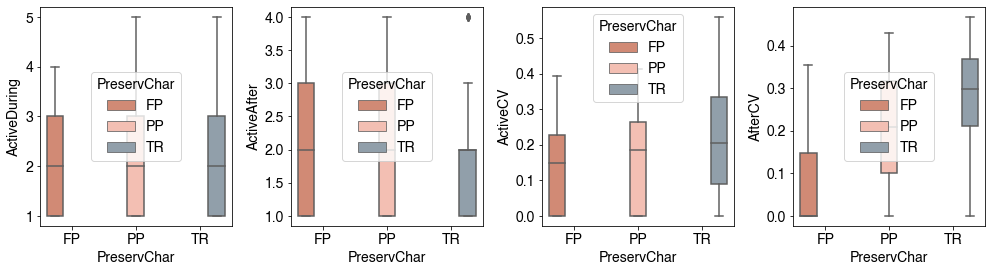

In [47]:
fig, ax = plt.subplots(1, 4, figsize = (14, 4), tight_layout = True)
sns.boxplot(data = allbars, x = 'PreservChar', y = 'ActiveDuring', hue = 'PreservChar', palette = pres_palette, ax = ax[0])
sns.boxplot(data = allbars, x = 'PreservChar', y = 'ActiveAfter', hue = 'PreservChar', palette = pres_palette, ax = ax[1])

sns.boxplot(data = allbars, x = 'PreservChar', y = 'ActiveCV', hue = 'PreservChar', palette = pres_palette, ax = ax[2])
sns.boxplot(data = allbars, x = 'PreservChar', y = 'AfterCV', hue = 'PreservChar', palette = pres_palette, ax = ax[3])

Activity metrics possibly? Want to look at numer of active channels/belt width, wetted width/active channels? In the context of preservation

In [31]:
int(ceil(len(ilocs)/2))

9

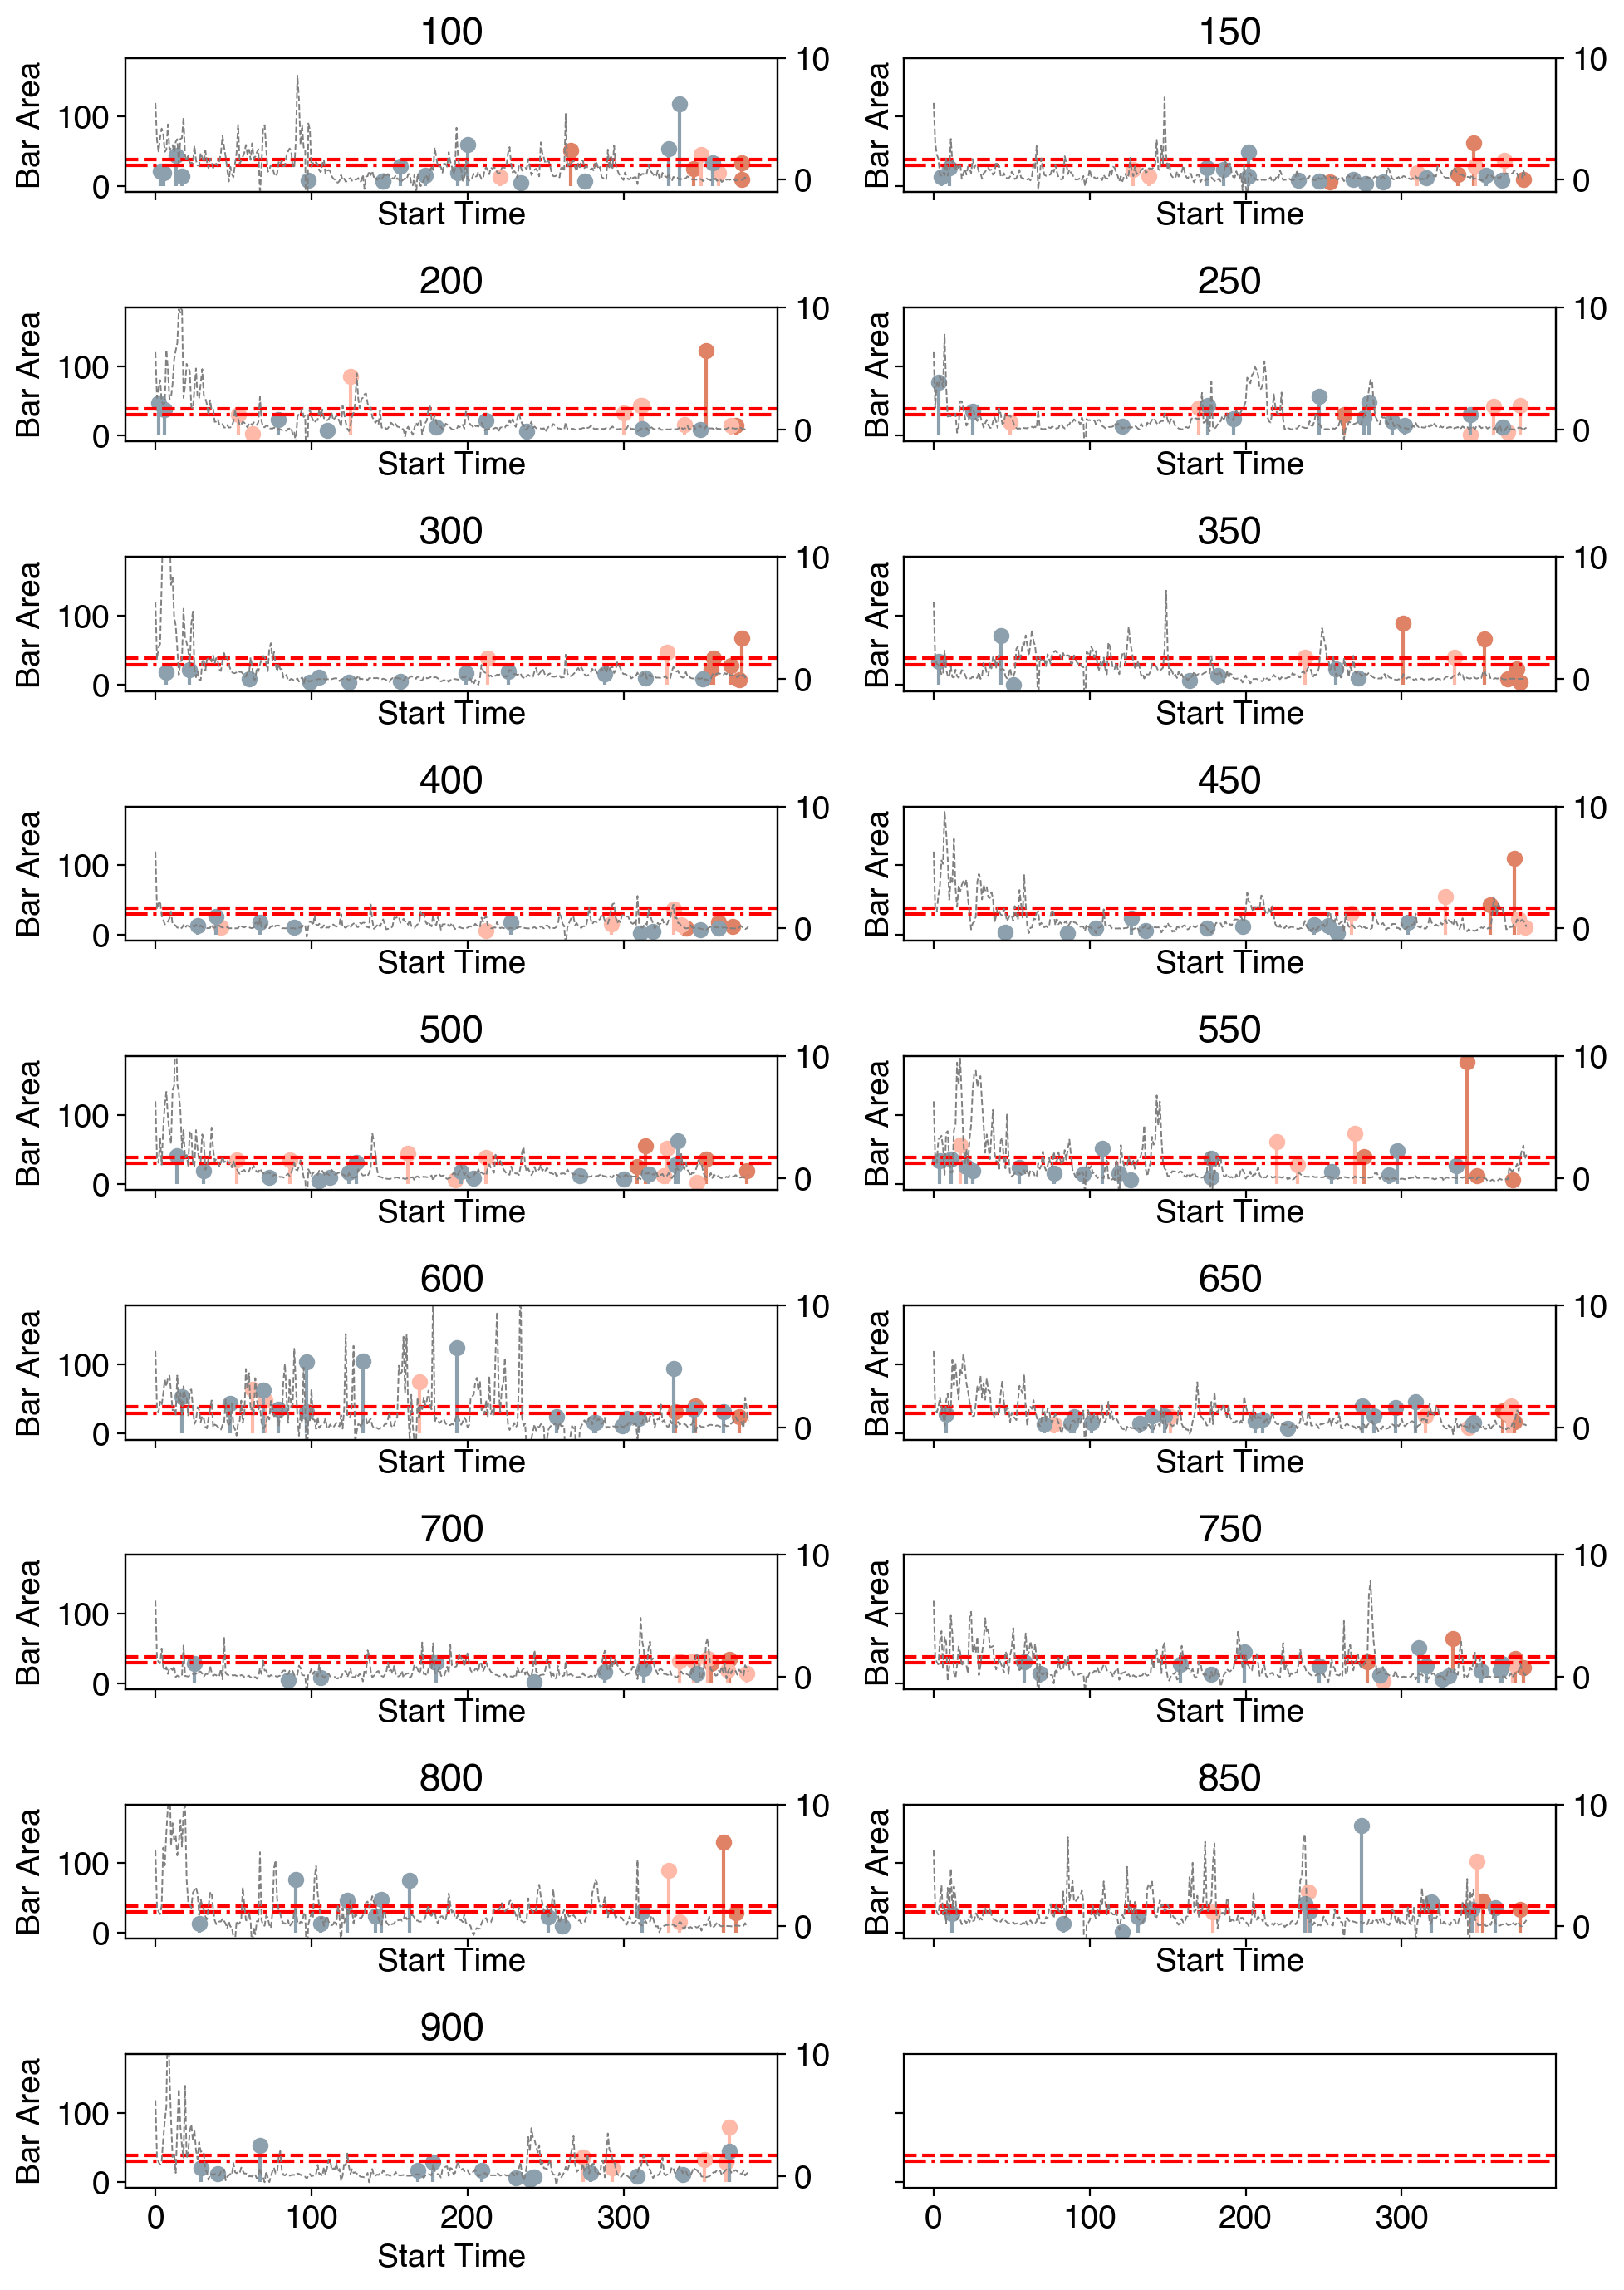

In [41]:
ilocs = np.arange(100, 901, 50)

fig, ax = plt.subplots(int(ceil(len(ilocs)/2)), 2, figsize = (10, 14), dpi = 200, sharex = True, tight_layout =True, sharey = True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['StartTime'], blank[blank['PreservChar']=='FP']['BarArea'], linefmt = pres_cols[0], label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['StartTime'], blank[blank['PreservChar']=='PP']['BarArea'], linefmt = pres_cols[1], label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['StartTime'], blank[blank['PreservChar']=='TR']['BarArea'], linefmt = pres_cols[2], label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    # ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    # ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.plot(total_wr_2h[i, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0)
    ax2.set_ylim(-1, 10)
    ax[idx].set_ylabel('Bar Area')
    ax[idx].set_xlabel('Start Time')
    
for a in ax:
    a.axhline(np.nanmean(allbars['BarArea'][allbars['PreservChar']=='FP']), c = 'r', ls = '--')
    a.axhline(np.nanmedian(allbars['BarArea'][allbars['PreservChar']=='FP']), c = 'r', ls = '-.')

In [ ]:
sns.boxplot(data = allbars, x = 'PreservChar', y = 'BarArea', hue = 'PreservChar', palette = pres_palette, whis = (5, 95))

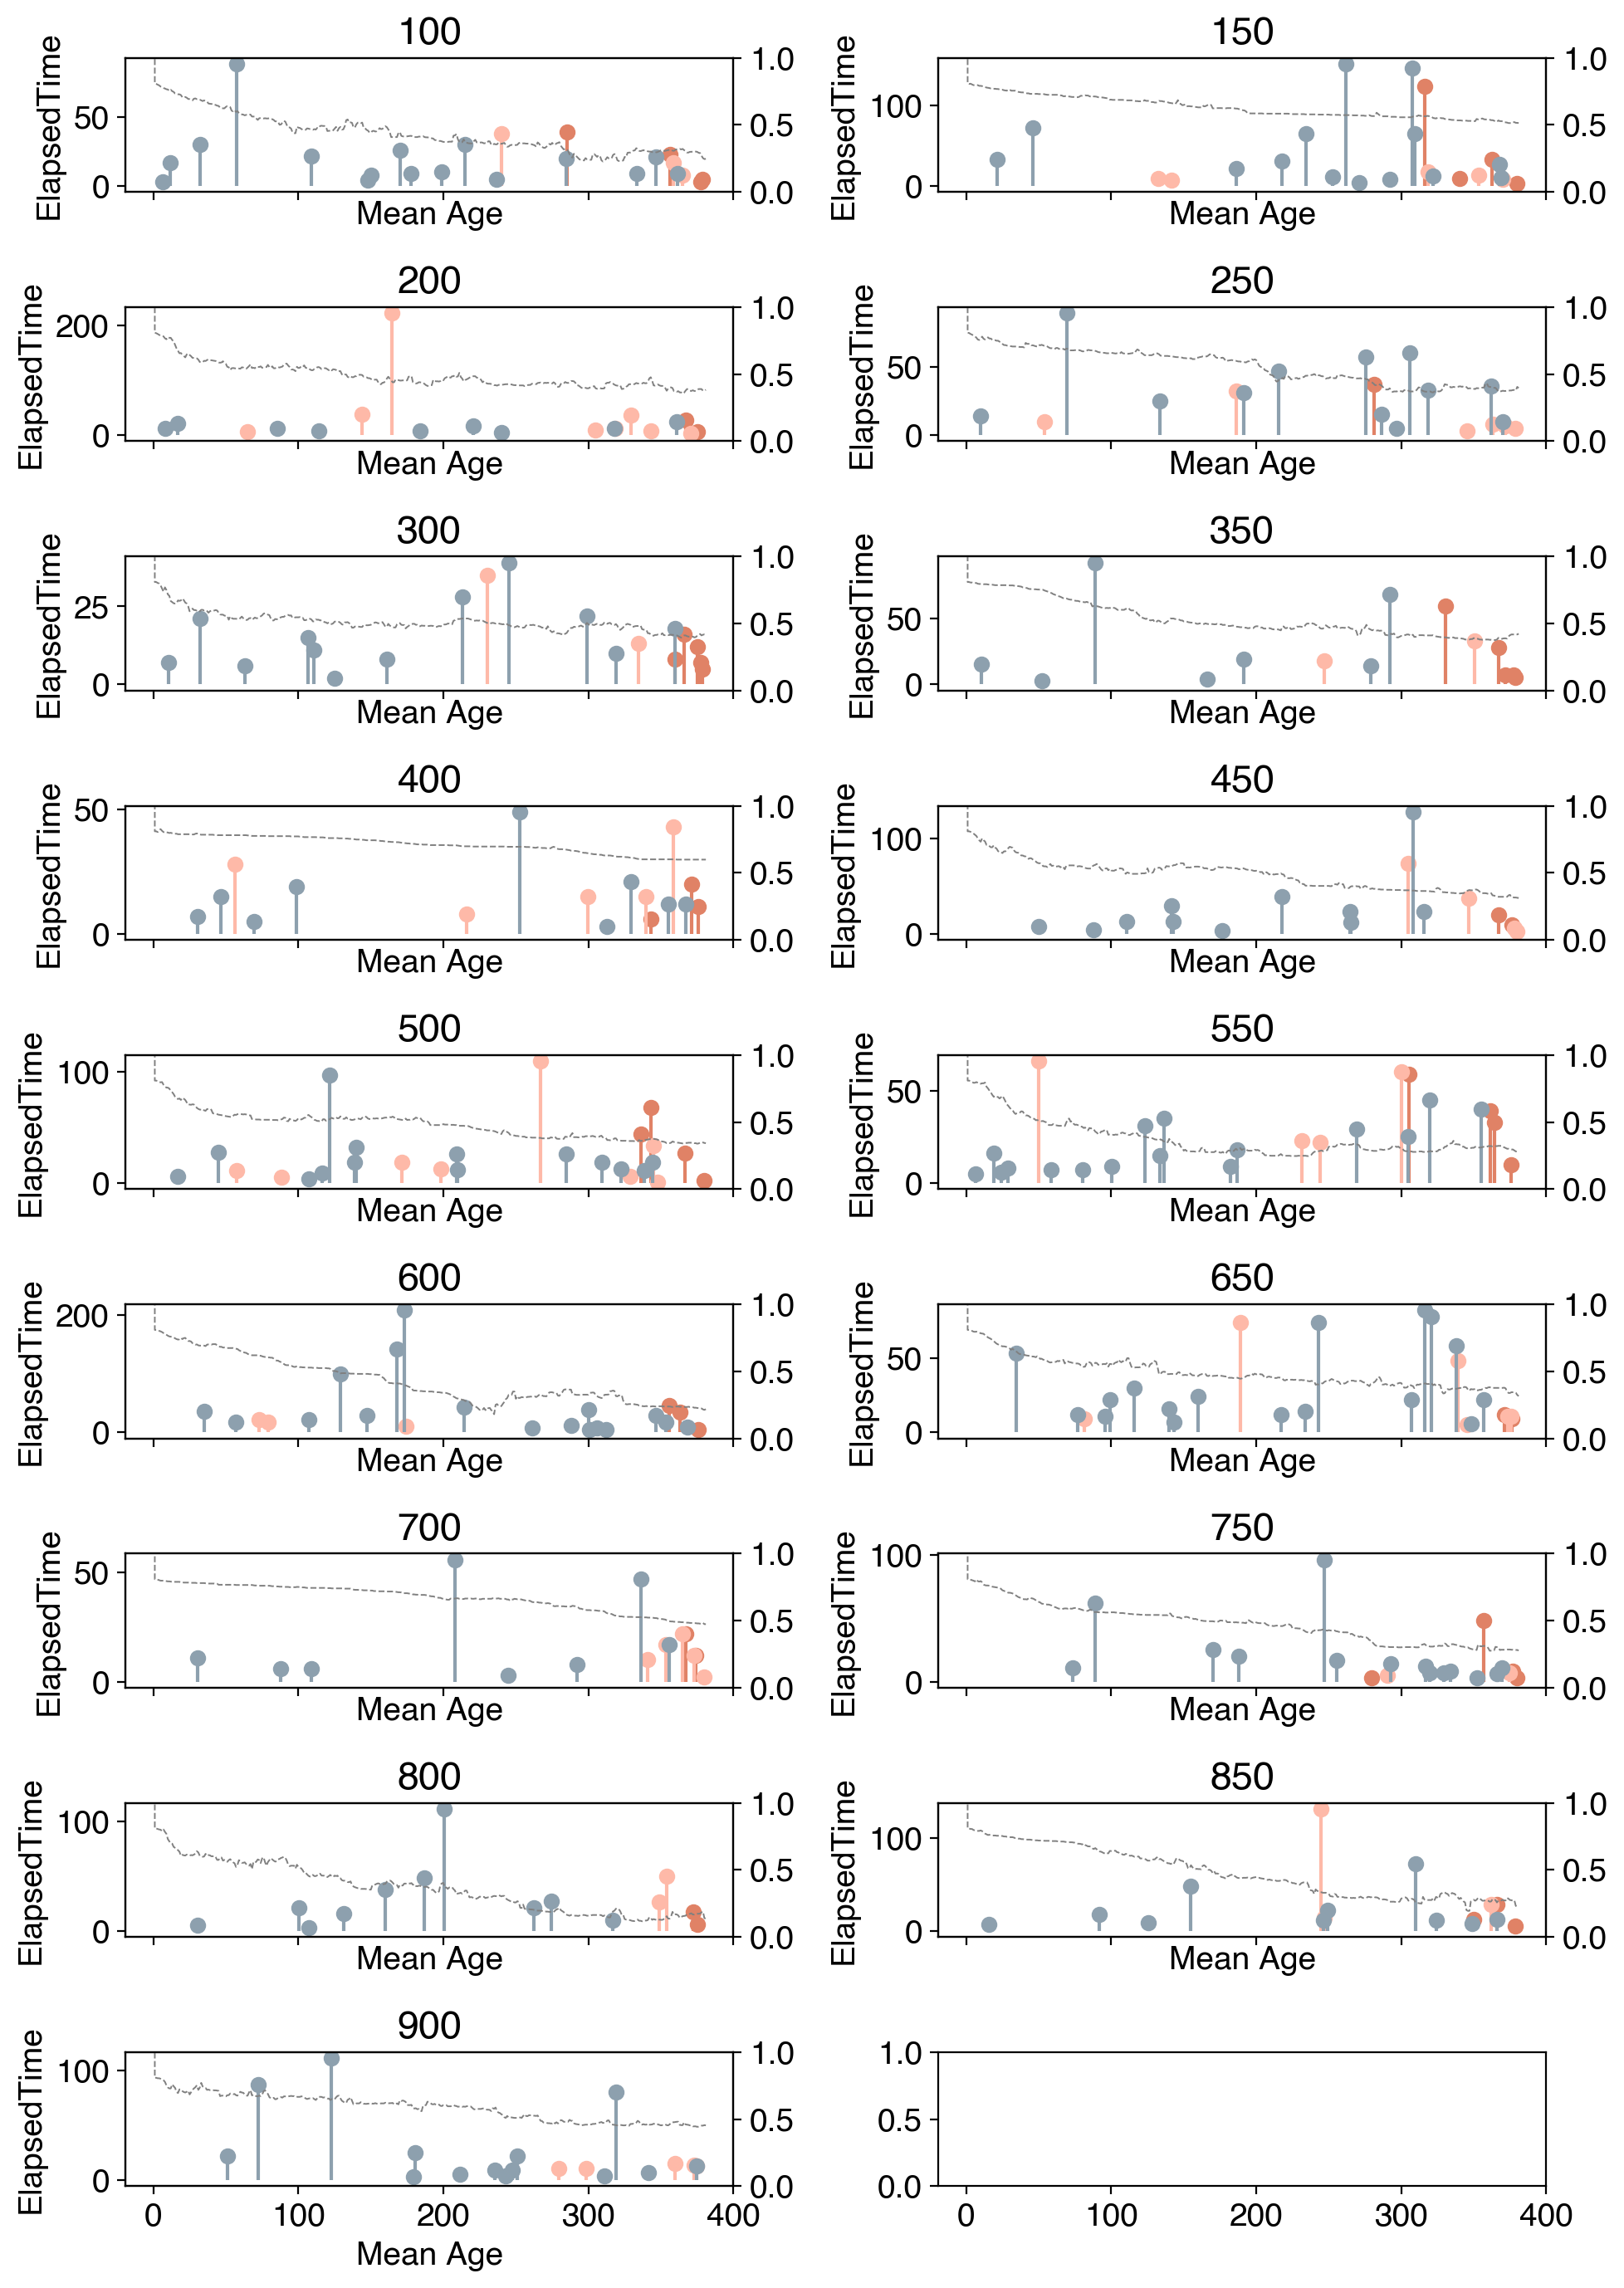

In [17]:
ilocs = np.arange(100, 901, 50)

fig, ax = plt.subplots(int(ceil(len(ilocs)/2)), 2, figsize = (10, 14), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['MeanAge'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = pres_cols[0], label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['MeanAge'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = pres_cols[1], label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['MeanAge'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = pres_cols[2], label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    # ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    # ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.plot(perc_untouched[i, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0)
    ax2.set_ylim(0, 1)
    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Mean Age')

In [21]:
wetted_width.shape

(1001, 382)

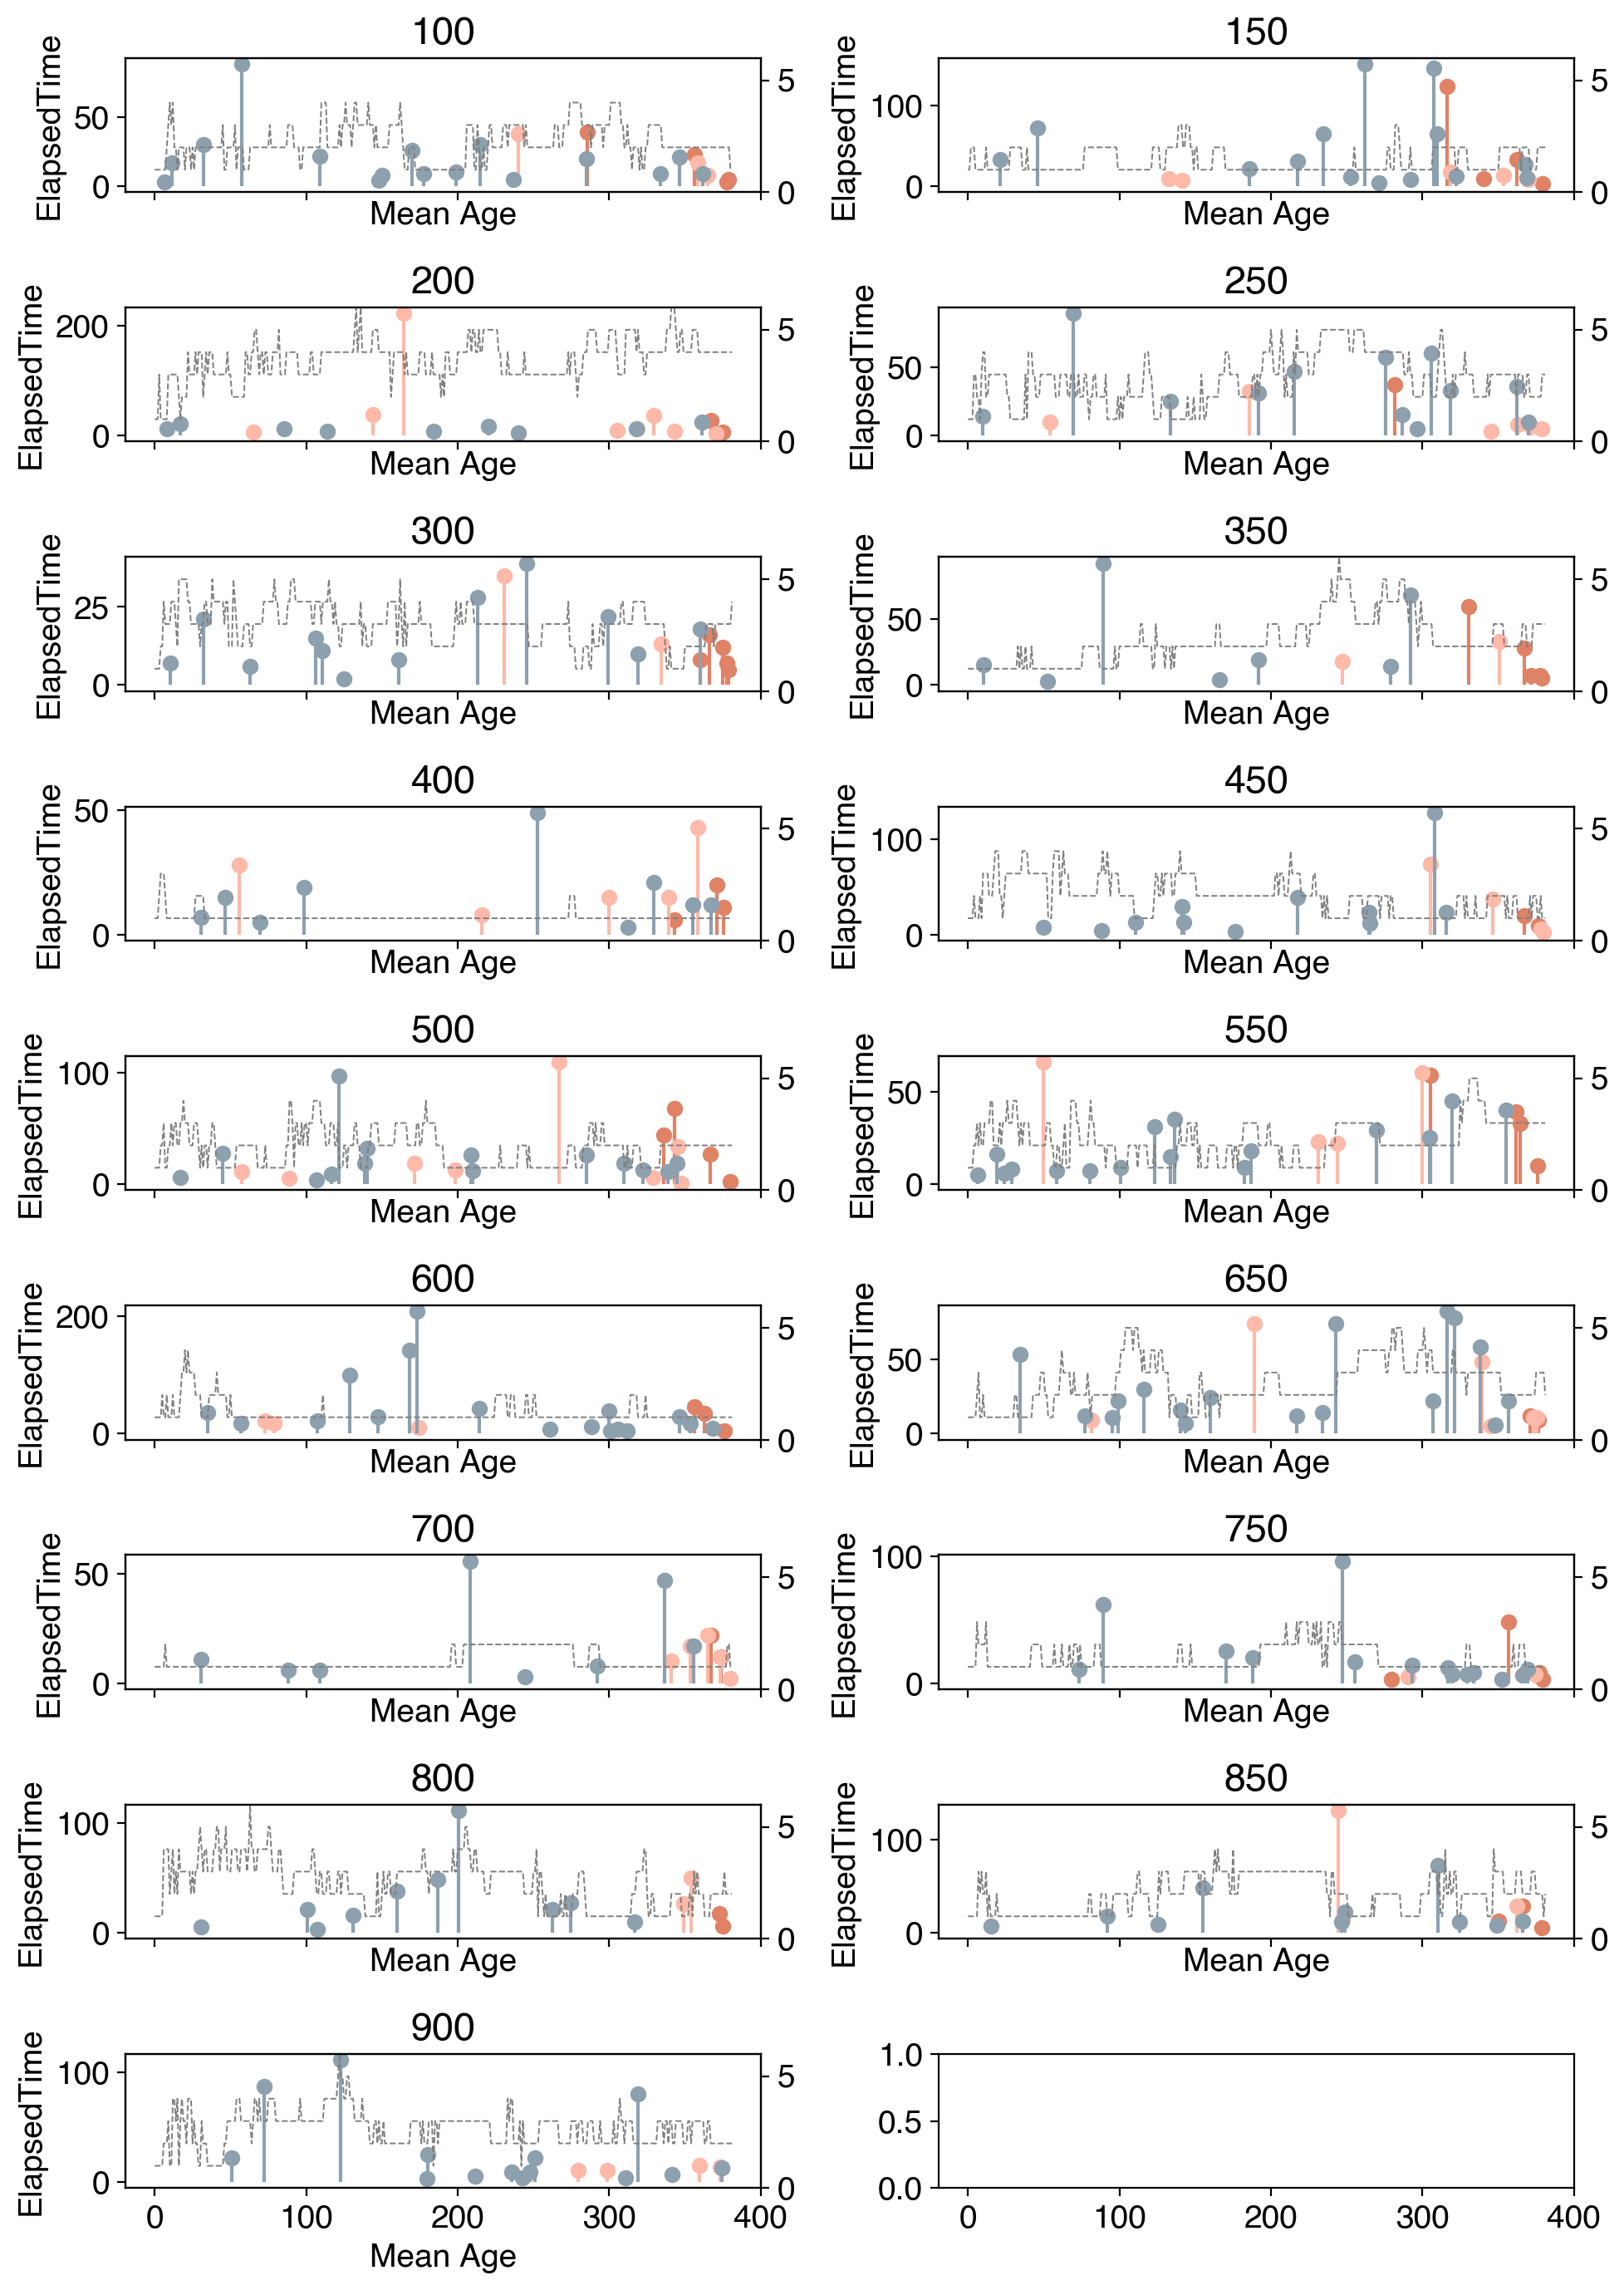

In [27]:
ilocs = np.arange(100, 901, 50)

fig, ax = plt.subplots(int(ceil(len(ilocs)/2)), 2, figsize = (10, 14), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['MeanAge'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = pres_cols[0], label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['MeanAge'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = pres_cols[1], label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['MeanAge'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = pres_cols[2], label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    # ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    # ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.plot(active_channels[i, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0)
    ax2.set_ylim(0, 6)
    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Mean Age')

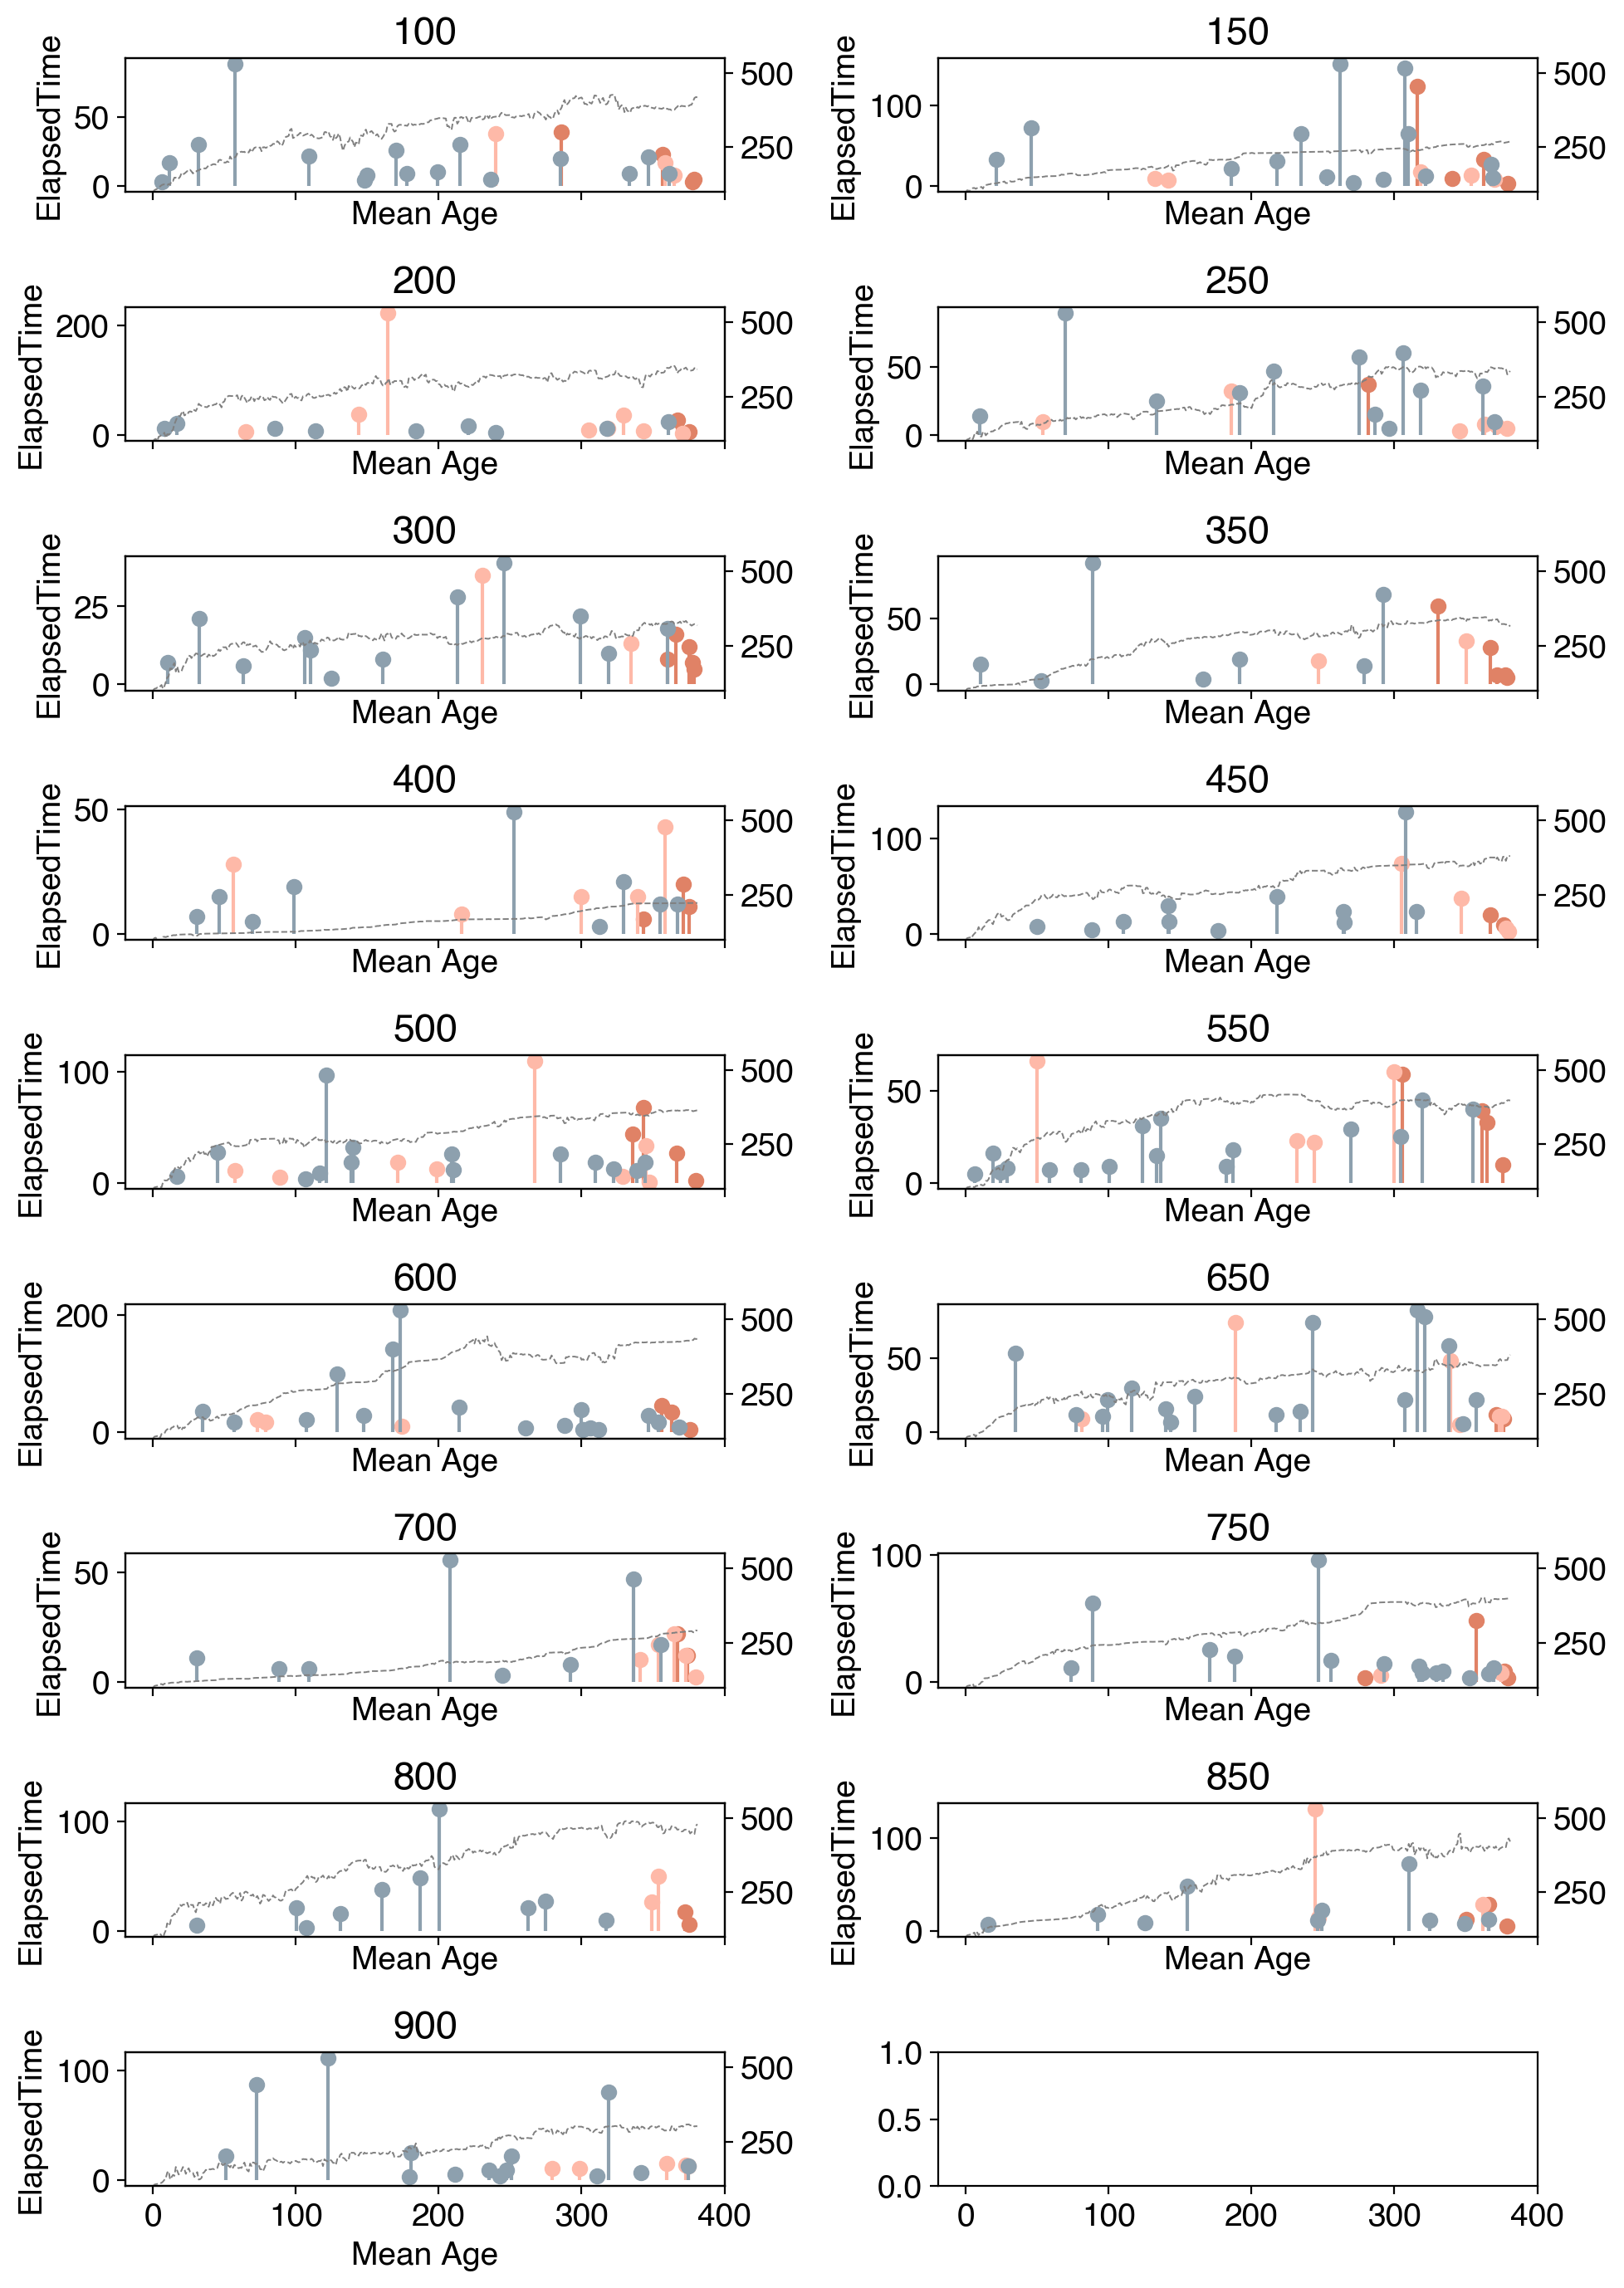

In [26]:
ilocs = np.arange(100, 901, 50)

fig, ax = plt.subplots(int(ceil(len(ilocs)/2)), 2, figsize = (10, 14), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['MeanAge'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = pres_cols[0], label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['MeanAge'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = pres_cols[1], label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['MeanAge'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = pres_cols[2], label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    # ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    # ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.plot(wetted_width[i, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0)
    ax2.set_ylim(100, 550)
    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Mean Age')